In [141]:
import pandas as pd
import numpy as np
from mlgear.utils import show
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [142]:
battlegrounds = ['Georgia', 'Texas', 'Ohio', 'Michigan', 'Pennsylvania', 'Maine', 'Iowa', 'South Carolina',
                 'North Carolina', 'Florida', 'Colorado', 'Nebraska', 'Arizona', 'Alaska', 'New Mexico',
                 'Nevada', 'National', 'Wisconsin']

def plot_polls(polls, grouper, election='president', year=2020, day_filter=30, count_filter=10,
               battlegrounds=battlegrounds):
    if not isinstance(grouper, list):
        grouper = [grouper]

    disp = polls
    
    if year is not None:
        if isinstance(year, list):
            disp = disp[(disp['year'].isin(year))]
        else:
            disp = disp[(disp['year'] == year)]
        
    if day_filter is not None:
        disp = disp[(disp['days_until'] < day_filter)]
        
    if election is not None:
        if isinstance(election, list):
            disp = disp[disp['election'].isin(election)]
        else:
            disp = disp[disp['election'] == election]
            
    if battlegrounds is not None:
        disp = disp[disp['state'].isin(battlegrounds)]

    if election is not None:
        disp = disp.groupby(['election'] + grouper)
    else:
        disp = disp.groupby(grouper)

    disp = disp[['polled_margin', 'actual_margin', 'margin_diff', 'margin_abs_diff']]
    disp = disp.agg(['mean', 'std', 'count']).reset_index()
    
    cols = grouper + ['polled_margin_mean', 'polled_margin_std', 'polled_margin_count',
                      'actual_margin_mean', 'actual_margin_count', 'actual_margin_std', 'margin_diff_mean',
                      'margin_diff_std', 'margin_diff_count', 'margin_abs_diff_mean', 'margin_abs_diff_std',
                      'margin_abs_diff_count']
    if election is not None:
        cols = ['election'] + cols
    disp.columns = cols
    
    disp = disp[disp['margin_abs_diff_count'] > count_filter]
        
    if disp.shape[0] > 0:
        show(disp.sort_values('margin_abs_diff_mean', ascending=False)[grouper + ['polled_margin_mean',
                                                                        'actual_margin_mean', 'margin_diff_mean',
                                                                        'polled_margin_count']].reset_index(drop=True),
             max_rows=None)

        if len(grouper) == 2:
            disp = disp.sort_values([grouper[0], 'margin_abs_diff_mean'])
        else:
            disp = disp.sort_values('margin_abs_diff_mean')
        meanx = disp['margin_abs_diff_mean'].values
        stdx = disp['margin_abs_diff_std'].values
        nx = disp['margin_abs_diff_count'].values
        labels = [l + ' (N={})'.format(nx[i]) for i, l in enumerate([' '.join(x) for x in disp[grouper].values])]
        cis_80 = 1.282 * (stdx / np.sqrt(nx))
        x_pos = [i for i, _ in enumerate(labels)]

        plt.figure(figsize=(20, int(len(labels))))
        for zone in ['ytick', 'xtick']:
            plt.rc(zone, labelsize=14)
            
        plt.barh(x_pos, meanx, color='green', xerr=cis_80)
        plt.yticks(x_pos, labels)
        
        title = 'Average Absolute Difference Between Polled and Actual Margin for '
        if isinstance(election, list):
            election = ', '.join(election)
        if isinstance(year, list):
            year = ', '.join([str(y) for y in year])
            
        if election is not None and year is not None:
            title += '{} {} (lower = better)'.format(election.title(), year)
        elif election is not None:
            title += '{} for all years (1999-2020) (lower = better)'.format(election.title())
        elif year is not None:
            title += 'all POTUS+Senate+Governor+GCB for {} (lower = better)'.format(year)
        else:
            title += 'all POTUS+Senate+Governor+GCB for all years (1999-2020) (lower = better)'
            
        plt.xlabel(title, fontsize=14)
        plt.show()

## Load Polls

In [143]:
polls = pd.read_csv('polls.csv')
polls

,election,state,year,stage,dem_candidate,pollster,N,methodology,population,days_until,...,dem_actual,rep_actual,ind_actual,dem_diff,rep_diff,polled_margin,actual_margin,margin_diff,margin_abs_diff,538grade_simple
0,president,Alabama,2004,general,NoName,SurveyUSA,735,Unknown,Unknown,6,...,37.099698,62.900302,-1.0,3.900302,-3.900302,-18.0,-25.800604,7.800604,7.800604,Unknown
1,president,Alabama,2004,general,NoName,Capital Survey,645,Unknown,Unknown,19,...,37.099698,62.900302,-1.0,0.900302,-0.900302,-24.0,-25.800604,1.800604,1.800604,Unknown
2,president,Alabama,2004,general,NoName,SurveyUSA,699,Unknown,Unknown,30,...,37.099698,62.900302,-1.0,-1.099698,1.099698,-28.0,-25.800604,-2.199396,2.199396,Unknown
3,president,Alabama,2004,general,NoName,Mobile Register,619,Unknown,Unknown,33,...,37.099698,62.900302,-1.0,-5.599698,5.599698,-37.0,-25.800604,-11.199396,11.199396,Unknown
4,president,Alabama,2004,general,NoName,ARG,699,Unknown,Unknown,47,...,37.099698,62.900302,-1.0,5.900302,-5.900302,-14.0,-25.800604,11.800604,11.800604,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27114,governor,Louisiana,2019,general,Edwards,Cygnal,800,IVR/Online/Live/Text,Unknown,8,...,51.330000,48.670000,0.0,-0.230000,0.230000,2.2,2.660000,-0.460000,0.460000,B
27115,governor,Louisiana,2019,general,Edwards,Targoz Market Research,640,Online,Unknown,6,...,51.330000,48.670000,0.0,0.670000,-0.670000,4.0,2.660000,1.340000,1.340000,C
27116,governor,Louisiana,2019,general,Edwards,Edgewater Research/My People Vote,661,IVR,Unknown,5,...,51.330000,48.670000,0.0,-1.180000,1.180000,0.3,2.660000,-2.360000,2.360000,C
27117,governor,Louisiana,2019,general,Edwards,JMC Analytics,600,IVR/Live/Text,Unknown,3,...,51.330000,48.670000,0.0,-1.080000,1.080000,0.5,2.660000,-2.160000,2.160000,C


## State Difficulty

## President 2020 ##
             state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0             Iowa            0.323333           -8.152965          8.476298   
1        Wisconsin            7.935849            0.627100          7.308750   
2             Ohio           -1.978929           -8.031962          6.053033   
3          Florida            2.310933           -3.358369          5.669302   
4         Michigan            7.629846            2.783528          4.846319   
5            Texas           -1.007000           -5.578594          4.571594   
6     Pennsylvania            5.087901            1.164884          3.923018   
7            Maine           13.283333            8.974351          4.308982   
8   North Carolina            2.557606           -1.348121          3.905726   
9   South Carolina           -7.854706          -11.676642          3.821937   
10         Arizona            3.254386            0.308710          2.945676   
11         Georgia 

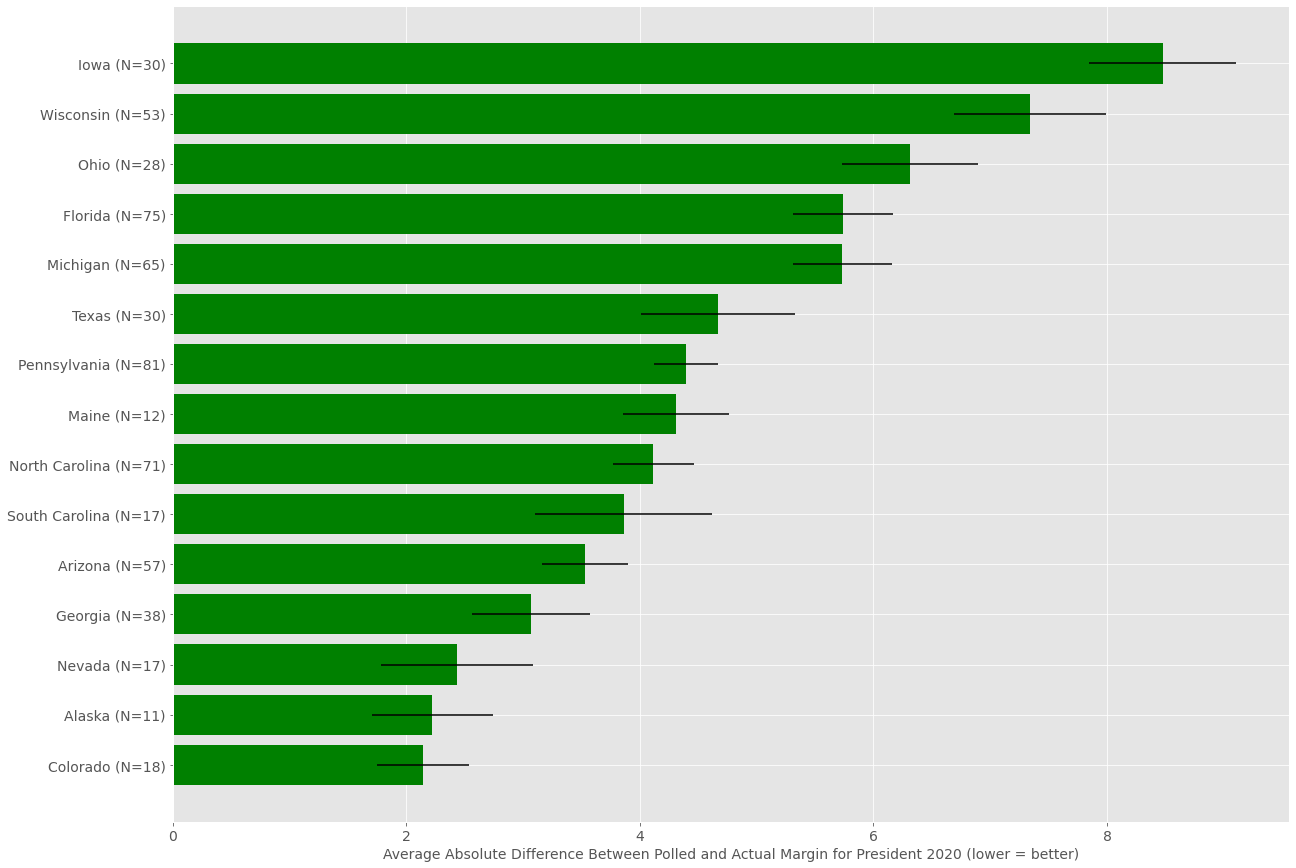

-
## Senate 2020 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0           Maine            3.500000           -8.501941         12.001941   
1            Iowa            1.529524           -6.478210          8.007734   
2        Michigan            7.136250            1.685031          5.451219   
3  North Carolina            3.619362           -1.746737          5.366098   
4         Arizona            6.638889            2.348697          4.290192   
5           Texas           -5.505263           -9.639404          4.134141   
6         Georgia            1.333103           -1.778976          3.112079   

   polled_margin_count  
0                   20  
1                   21  
2                   40  
3                   47  
4                   36  
5                   19  
6                   29  
(7, 5)


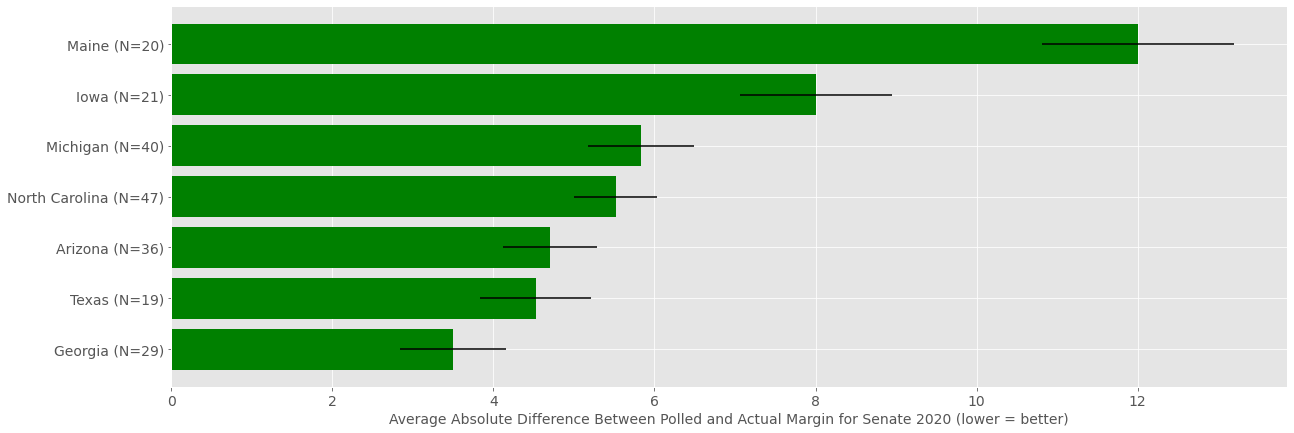

-
## Governor 2020 ##
-
## President 2018 ##
-
## Senate 2018 ##
      state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0      Ohio           11.450000            6.842886          4.607114   
1    Nevada            0.469310            5.027926         -4.558615   
2  Michigan            9.221429            6.502801          2.718627   
3   Arizona            0.338889            2.346432         -2.007544   
4     Texas           -5.302083           -2.564831         -2.737252   
5   Florida            1.421519           -0.121426          1.542945   

   polled_margin_count  
0                   12  
1                   29  
2                   28  
3                   54  
4                   24  
5                   79  
(6, 5)


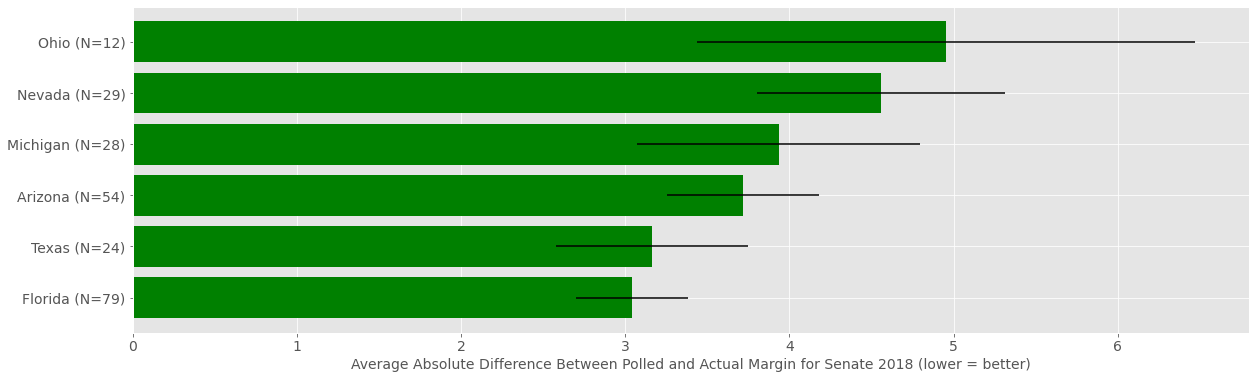

-
## Governor 2018 ##
      state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0   Florida            3.108750           -0.400000          3.508750   
1   Arizona          -15.321429          -14.160000         -1.161429   
2  Michigan            8.600000            9.560000         -0.960000   

   polled_margin_count  
0                   32  
1                   14  
2                   12  
(3, 5)


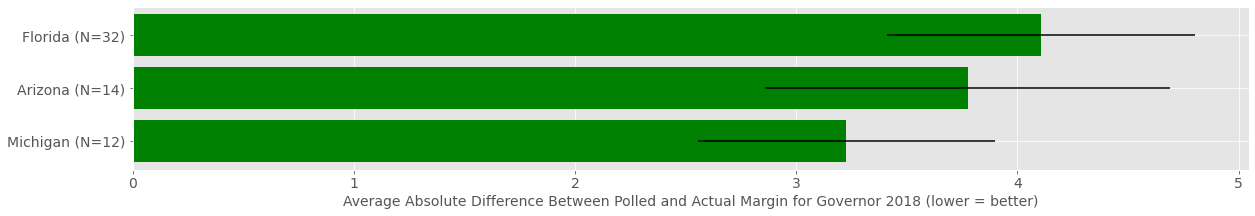

-
## President 2016 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0            Ohio           -2.005000           -8.070000          6.065000   
1       Wisconsin            5.211538           -0.770000          5.981538   
2  North Carolina            1.743462           -3.660000          5.403462   
3        Michigan            4.650000           -0.220000          4.870000   
4    Pennsylvania            3.795862           -0.710000          4.505862   
5         Florida            1.372222           -1.190000          2.562222   
6          Nevada            0.552381            2.420000         -1.867619   
7         Georgia           -3.173125           -5.090000          1.916875   
8         Arizona           -2.000000           -3.500000          1.500000   
9        Colorado            3.031429            4.910000         -1.878571   

   polled_margin_count  
0                   18  
1                   13  
2                   26  
3      

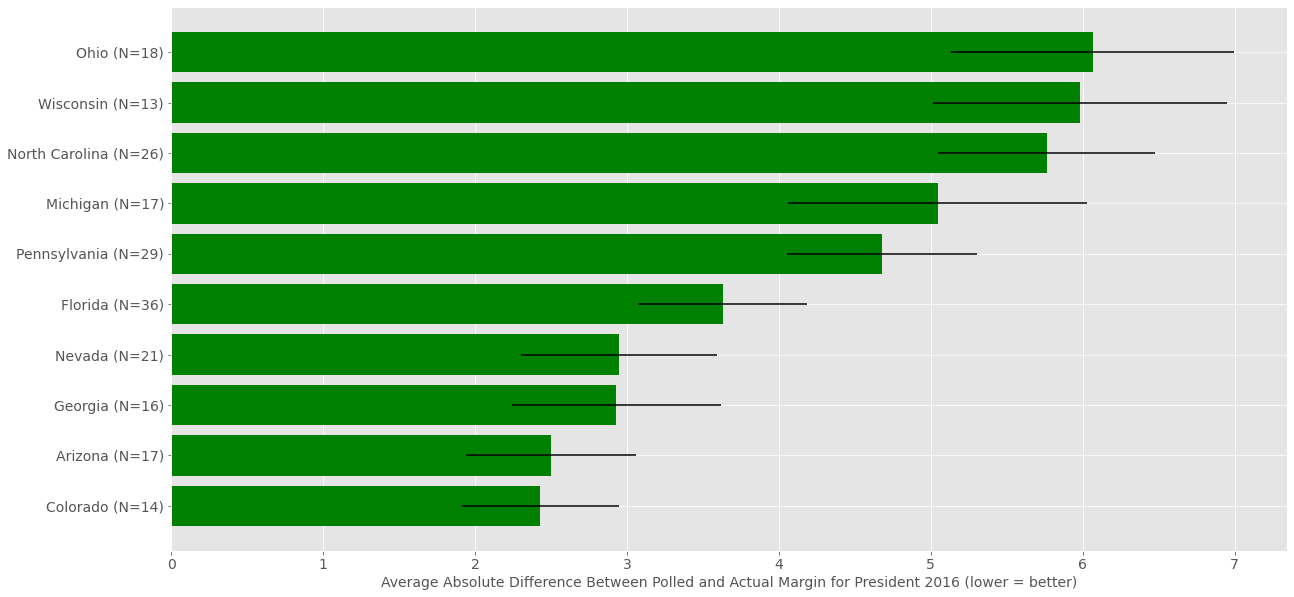

-
## Senate 2016 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0  North Carolina           -1.027273           -5.690000          4.662727   
1         Georgia          -10.683333          -13.750000          3.066667   
2    Pennsylvania            2.556522           -1.430000          3.986522   
3         Florida           -5.253333           -7.670000          2.416667   
4         Arizona           -9.250000          -12.960000          3.710000   
5          Nevada            1.381250            2.430000         -1.048750   

   polled_margin_count  
0                   22  
1                   12  
2                   23  
3                   30  
4                   12  
5                   16  
(6, 5)


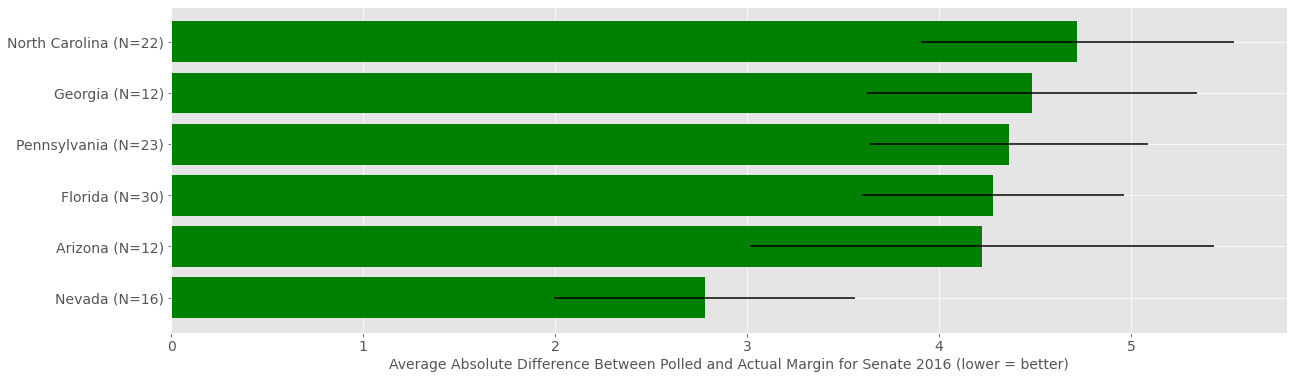

-
## Governor 2016 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0  North Carolina            3.428571            0.220000          3.208571   

   polled_margin_count  
0                   14  
(1, 5)


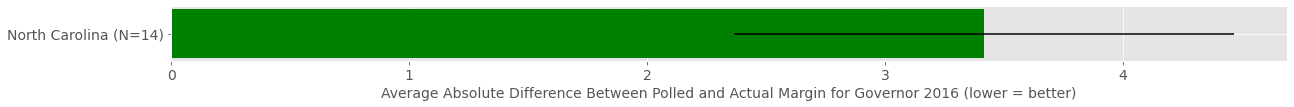

-
## President 2014 ##
-
## Senate 2014 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0         Georgia           -1.035517           -7.841379          6.805862   
1            Iowa           -1.603448           -8.356552          6.753103   
2  North Carolina            0.551724           -1.681379          2.233103   
3        Colorado           -1.741176           -2.804118          1.062941   

   polled_margin_count  
0                   29  
1                   29  
2                   29  
3                   34  
(4, 5)


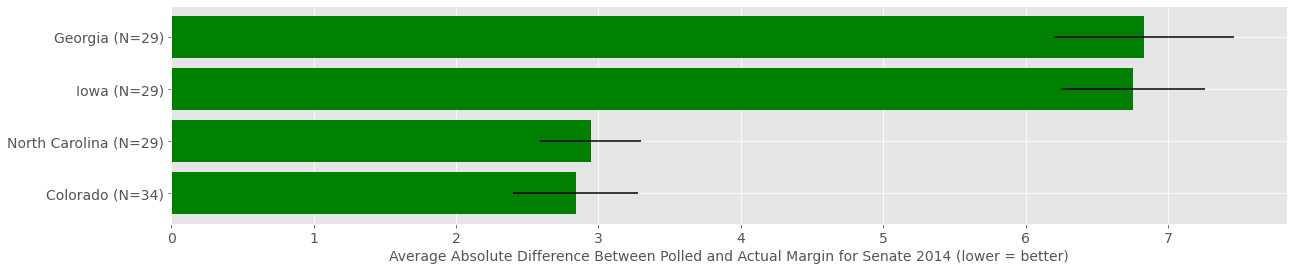

-
## Governor 2014 ##
      state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0      Iowa          -18.000000          -21.720000          3.720000   
1   Georgia           -3.421053           -7.860000          4.438947   
2  Colorado            0.764706            3.350000         -2.585294   
3  Michigan           -1.833333           -4.060000          2.226667   
4   Florida            0.064706           -1.070000          1.134706   

   polled_margin_count  
0                   13  
1                   19  
2                   17  
3                   12  
4                   17  
(5, 5)


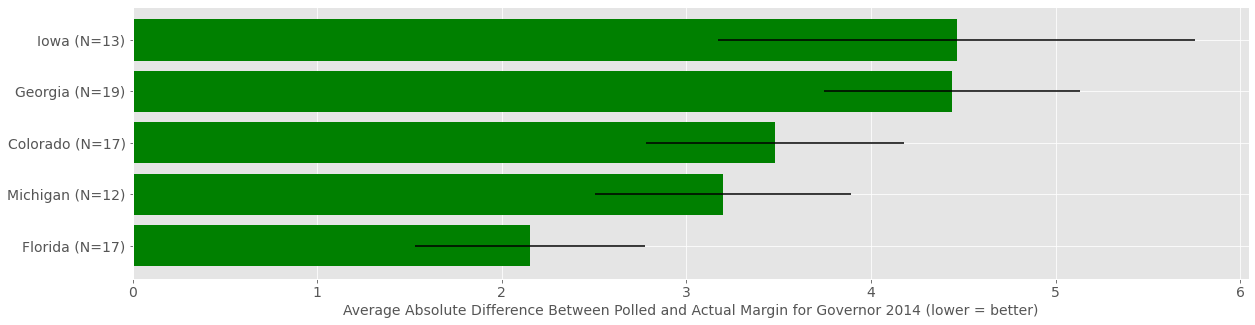

-
## President 2012 ##
             state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0         Nebraska          -16.018750          -22.075488          6.056738   
1         Michigan            5.110000            9.559920         -4.449920   
2         Colorado            1.264384            5.453160         -4.188777   
3             Iowa            1.983871            5.881885         -3.898014   
4        Wisconsin            3.437838            7.002679         -3.564841   
5       New Mexico            7.294118           10.434971         -3.140853   
6           Nevada            3.768627            6.772705         -3.004077   
7   North Carolina           -2.156522           -2.059527         -0.096995   
8          Florida           -0.882500            0.879972         -1.762472   
9     Pennsylvania            4.276364            5.439470         -1.163106   
10            Ohio            2.144872            3.013051         -0.868180   
11         Georgi

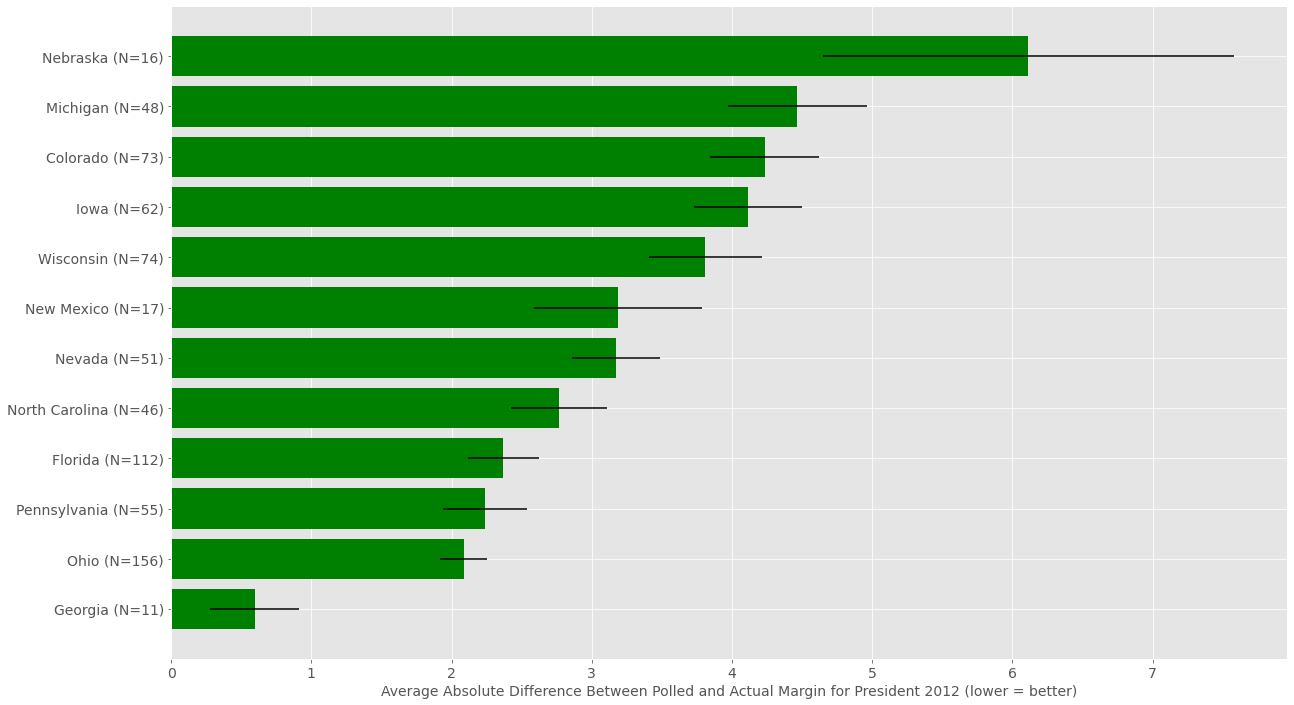

-
## Senate 2012 ##
          state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0      Nebraska           -6.900000          -15.546066          8.646066   
1      Michigan           13.407333           21.322728         -7.915395   
2       Florida            7.699412           13.233583         -5.534172   
3     Wisconsin            0.888525            5.658769         -4.770245   
4  Pennsylvania            5.758491            9.219174         -3.460683   
5       Arizona           -4.000000           -3.131553         -0.868447   
6    New Mexico            7.076923            5.900562          1.176361   
7          Ohio            4.864356            6.198588         -1.334232   
8        Nevada           -3.625806           -1.241903         -2.383903   

   polled_margin_count  
0                   19  
1                   30  
2                   68  
3                   61  
4                   53  
5                   15  
6                   13  
7        

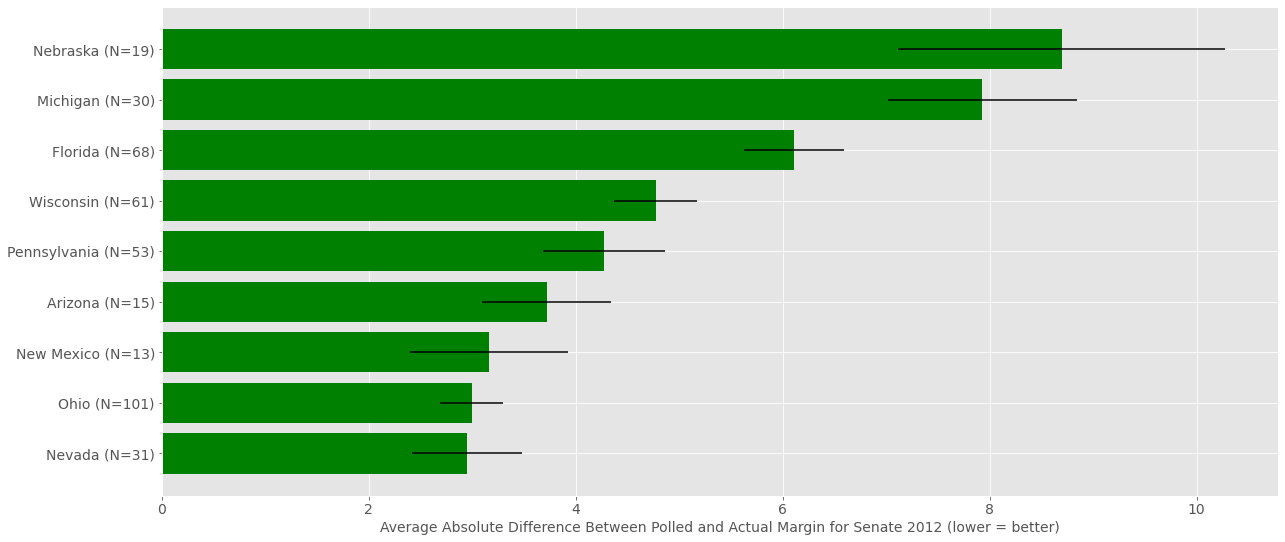

-
## Governor 2012 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0       Wisconsin           -5.083333           -6.822011          1.738678   
1  North Carolina          -13.083333          -11.632780         -1.450553   

   polled_margin_count  
0                   24  
1                   24  
(2, 5)


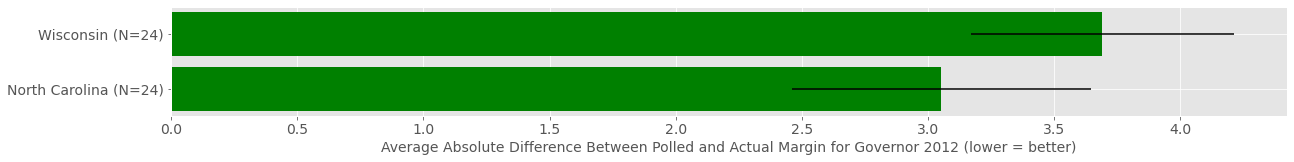

-
## President 2010 ##
-
## Senate 2010 ##
          state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0        Nevada           -3.175000            5.952522         -9.127522   
1      Colorado           -2.190476            1.741955         -3.932431   
2  Pennsylvania           -4.250000           -2.018093         -2.231907   
3     Wisconsin           -6.807692           -4.874361         -1.933331   
4          Ohio          -17.200000          -17.785974          0.585974   

   polled_margin_count  
0                   40  
1                   42  
2                   60  
3                   26  
4                   30  
(5, 5)


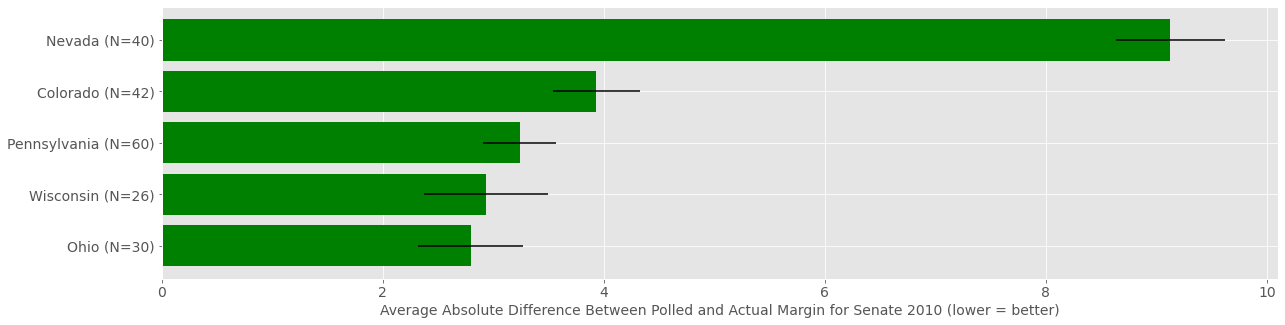

-
## Governor 2010 ##
           state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0         Alaska           -5.062500           -5.132692          0.070192   
1       Colorado            5.785714           15.767035         -9.981321   
2         Nevada          -17.275862          -12.196885         -5.078977   
3     New Mexico           -8.785714           -6.873889         -1.911826   
4        Florida           -0.016129           -1.192924          1.176795   
5      Wisconsin           -7.809524           -5.792016         -2.017508   
6   Pennsylvania           -8.351852           -8.985351          0.633500   
7        Georgia           -7.652174          -10.238728          2.586554   
8          Texas          -10.714286          -12.932814          2.218529   
9           Ohio           -3.754386           -2.270860         -1.483526   
10      Michigan          -17.600000          -18.477213          0.877213   

    polled_margin_count  
0              

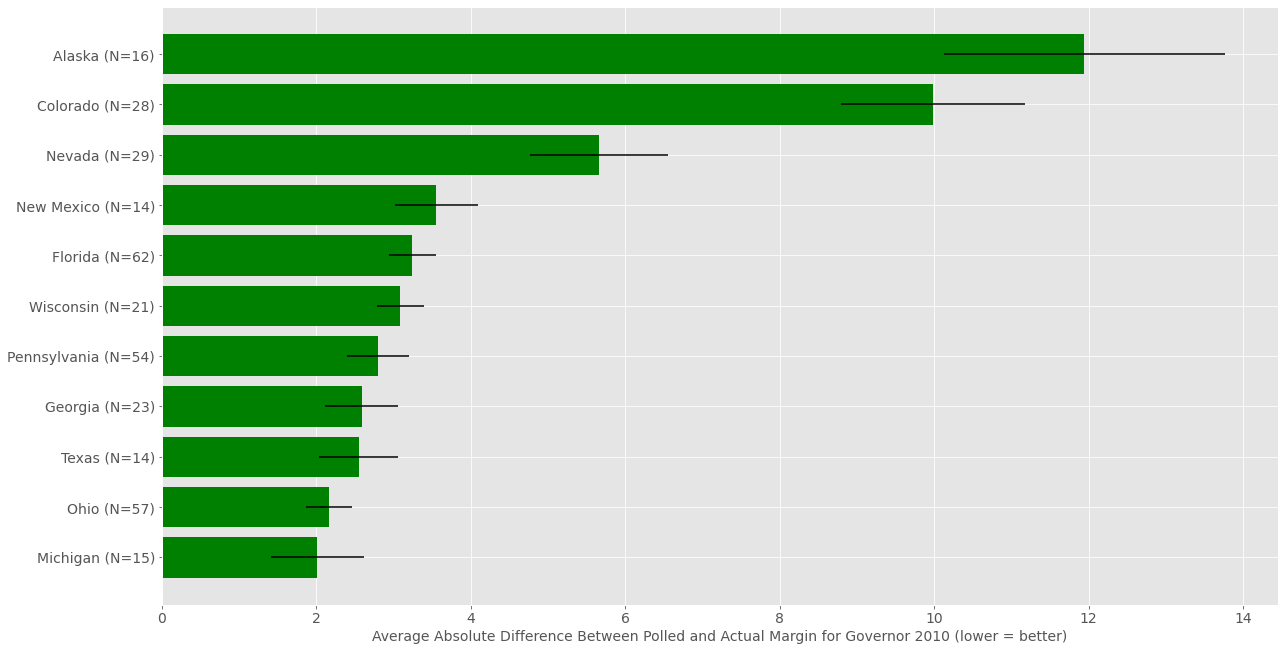

-
## President 2008 ##
             state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0           Nevada            4.934328           12.708168         -7.773840   
1           Alaska          -15.213333          -21.969685          6.756351   
2       New Mexico            9.150000           15.279850         -6.129850   
3          Arizona           -3.954545           -8.583013          4.628468   
4            Maine           15.881481           17.561554         -1.680072   
5             Ohio            4.155000            4.647014         -0.492014   
6        Wisconsin           11.058621           14.069697         -3.011076   
7             Iowa           12.786111            9.658167          3.127944   
8         Colorado            6.673239            9.067181         -2.393941   
9         Michigan           14.578571           16.670555         -2.091983   
10  South Carolina          -11.333333           -9.062445         -2.270888   
11    Pennsylvani

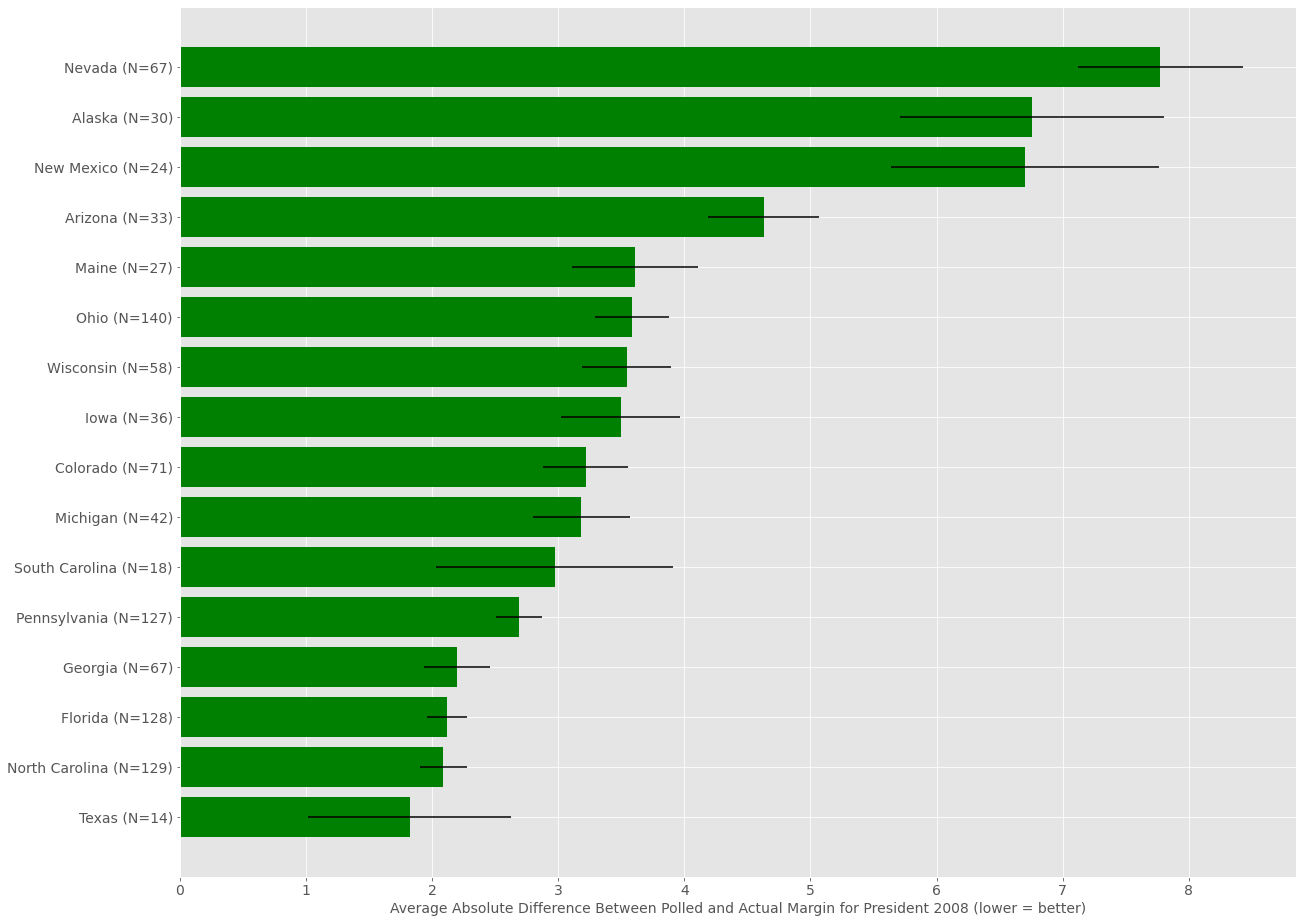

-
## Senate 2008 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0           Maine          -15.111111          -22.761980          7.650869   
1        Michigan           22.545455           29.574109         -7.028655   
2          Alaska            6.954545            1.300552          5.653993   
3      New Mexico           17.052632           22.657040         -5.604408   
4  North Carolina            3.629730            8.678767         -5.049037   
5            Iowa           21.700000           25.411715         -3.711715   
6         Georgia           -3.857143           -5.597323          1.740180   
7           Texas          -10.909091          -12.164722          1.255631   
8        Colorado           11.027778           10.659346          0.368432   

   polled_margin_count  
0                   27  
1                   22  
2                   22  
3                   19  
4                   74  
5                   20  
6             

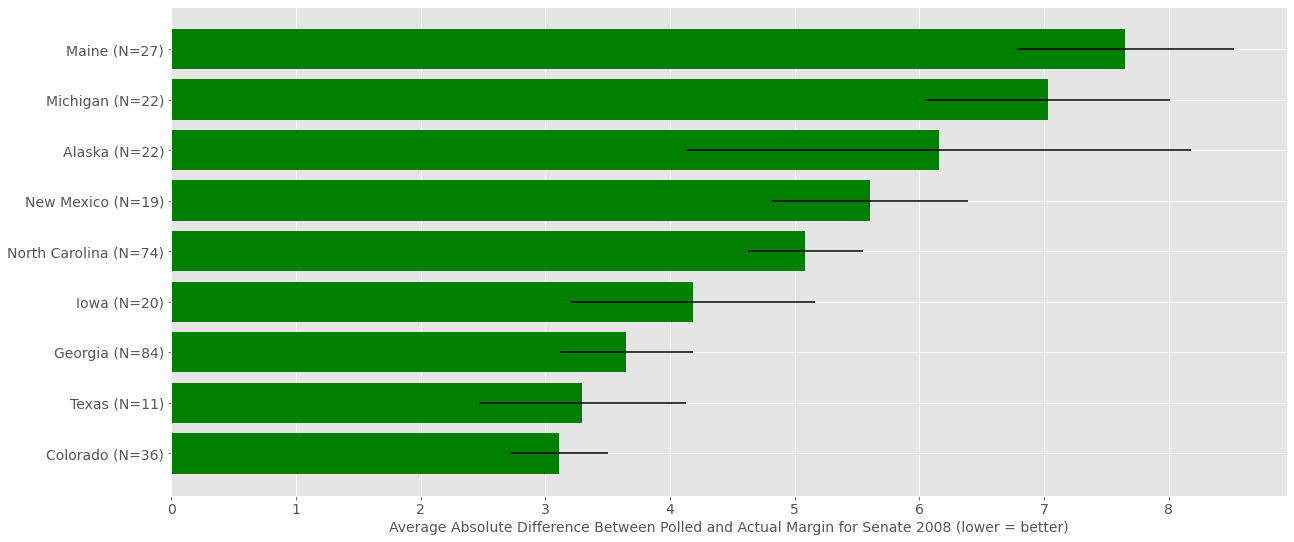

-
## Governor 2008 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0  North Carolina            1.128571            3.464532         -2.335960   

   polled_margin_count  
0                   42  
(1, 5)


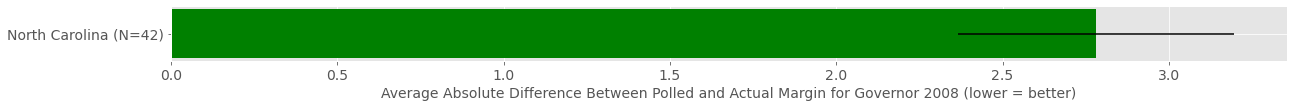

-
## President 2006 ##
-
## Senate 2006 ##
          state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0         Texas          -29.754545          -26.029132         -3.725413   
1  Pennsylvania           11.274074           17.370038         -6.095964   
2      Michigan           11.832727           15.862170         -4.029443   
3          Ohio           10.710204           12.341814         -1.631610   
4       Arizona           -7.679167          -10.080818          2.401651   
5       Florida           24.350000           22.436890          1.913110   
6        Nevada          -13.647059          -14.722242          1.075184   

   polled_margin_count  
0                   11  
1                   54  
2                   55  
3                   49  
4                   24  
5                   32  
6                   17  
(7, 5)


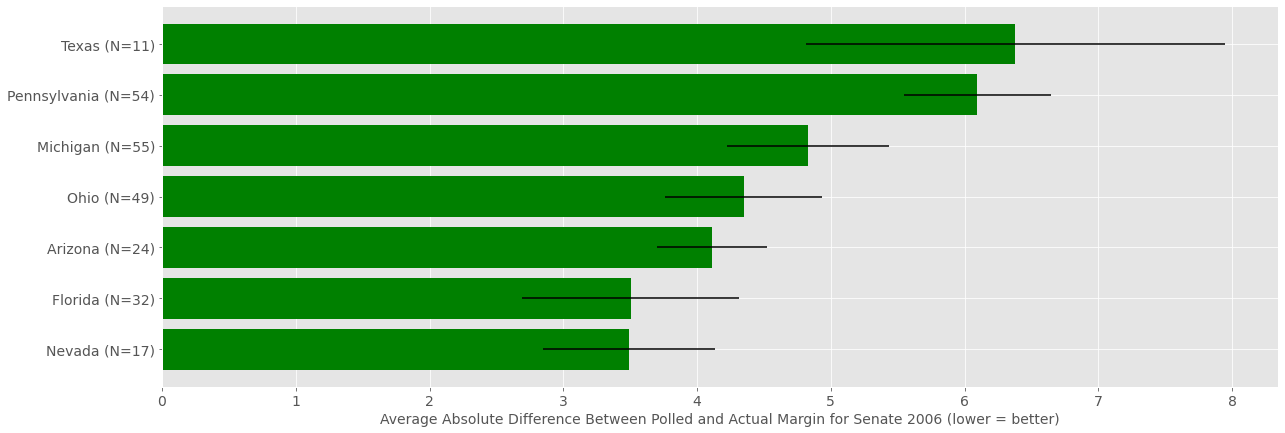

-
## Governor 2006 ##
             state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0          Arizona           22.387500           27.562883         -5.175383   
1   South Carolina          -20.000000          -10.316874         -9.683126   
2             Iowa            2.270000            9.570755         -7.300755   
3             Ohio           21.583333           24.160719         -2.577386   
4         Colorado           15.504348           17.126055         -1.621707   
5         Michigan            8.862222           10.819800         -1.957578   
6          Georgia          -15.947368          -20.250170          4.302802   
7        Wisconsin            5.086957            7.567572         -2.480616   
8           Alaska           -3.985714           -7.961691          3.975977   
9     Pennsylvania           21.210000           20.770750          0.439250   
10         Florida           -7.546667           -7.221346         -0.325320   
11          Nevada

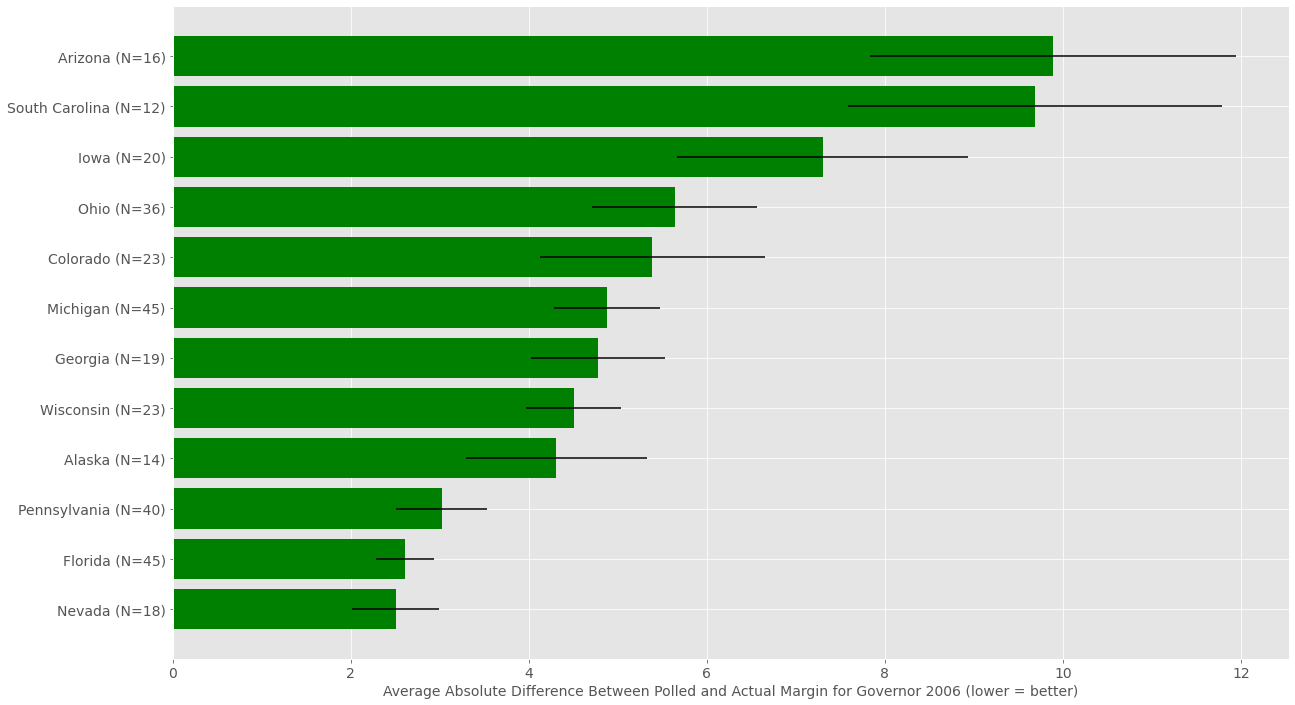

-
## President 2004 ##
             state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0   North Carolina           -7.409091          -12.474064          5.064973   
1          Florida           -1.333000           -5.037002          3.704002   
2          Arizona           -9.117647          -10.518466          1.400819   
3       New Mexico           -0.807692           -0.795798         -0.011894   
4        Wisconsin           -1.083019            0.382555         -1.465573   
5          Georgia          -14.840000          -16.671796          1.831796   
6         Michigan            3.434545            3.441096         -0.006550   
7           Nevada           -4.781818           -2.617651         -2.164167   
8             Ohio           -0.371264           -2.106752          1.735488   
9             Iowa           -1.200000           -0.673853         -0.526147   
10        Colorado           -4.595238           -4.710687          0.115449   
11    Pennsylvani

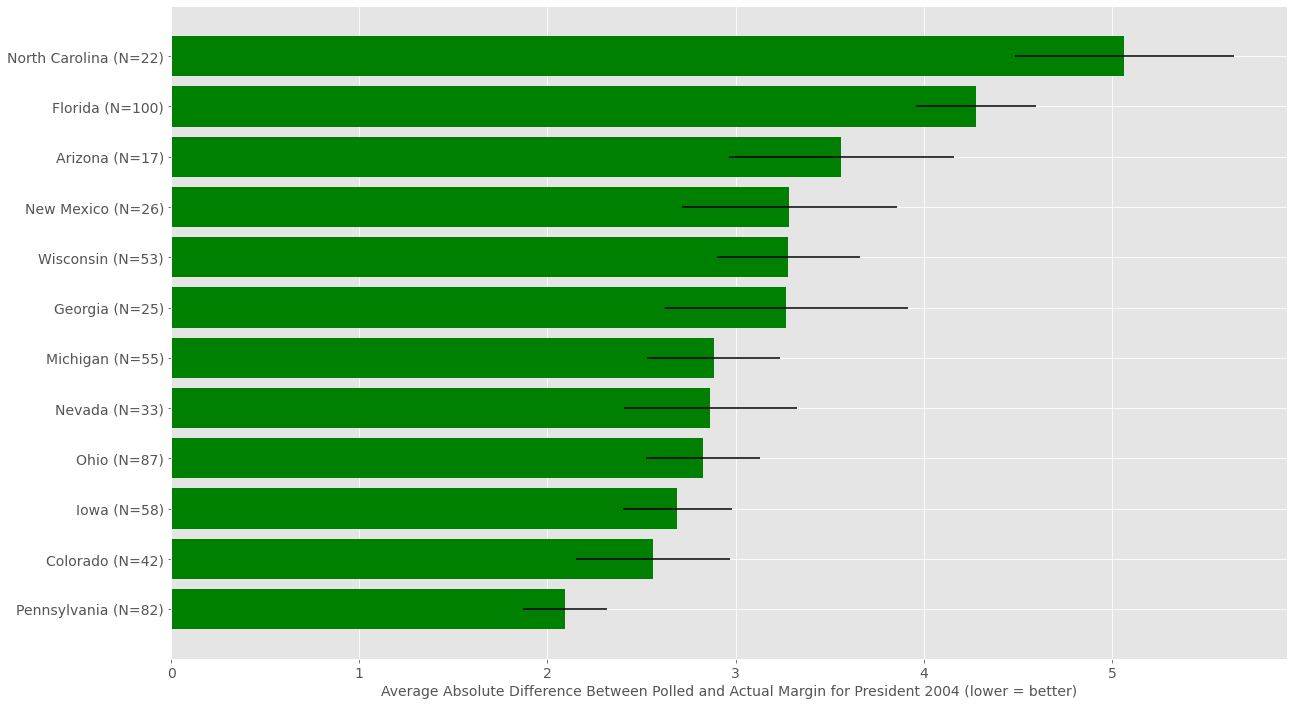

-
## Senate 2004 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0    Pennsylvania          -18.965116          -11.024343         -7.940773   
1       Wisconsin           14.333333           11.276615          3.056718   
2        Colorado            2.842105            4.839609         -1.997503   
3          Nevada           25.800000           26.551431         -0.751431   
4  South Carolina           -7.583333           -9.733709          2.150376   
5            Ohio          -27.843750          -27.711732         -0.132018   
6  North Carolina           -1.928571           -4.623489          2.694917   
7         Georgia          -15.461538          -18.167918          2.706379   
8         Florida           -0.042857           -1.126425          1.083568   

   polled_margin_count  
0                   43  
1                   15  
2                   38  
3                   15  
4                   12  
5                   32  
6             

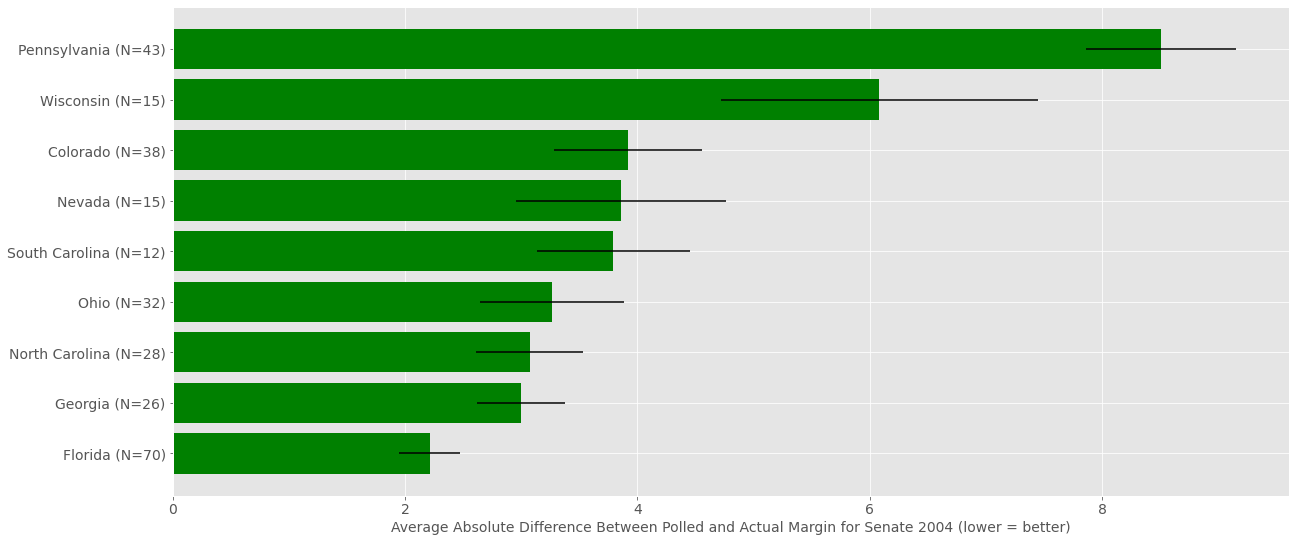

-
## Governor 2004 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0  North Carolina           13.692308           12.810800          0.881507   

   polled_margin_count  
0                   13  
(1, 5)


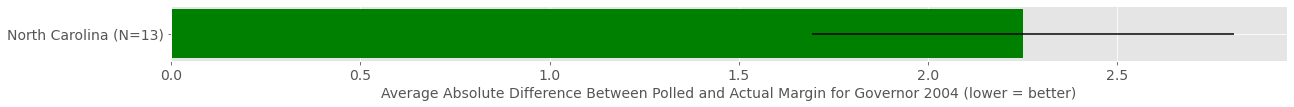

-
## President 2002 ##
-
## Senate 2002 ##
            state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0           Texas           -5.833333          -12.053133          6.219800   
1        Colorado           -1.705882           -5.014893          3.309010   
2  North Carolina           -5.733333           -8.660290          2.926956   

   polled_margin_count  
0                   24  
1                   17  
2                   15  
(3, 5)


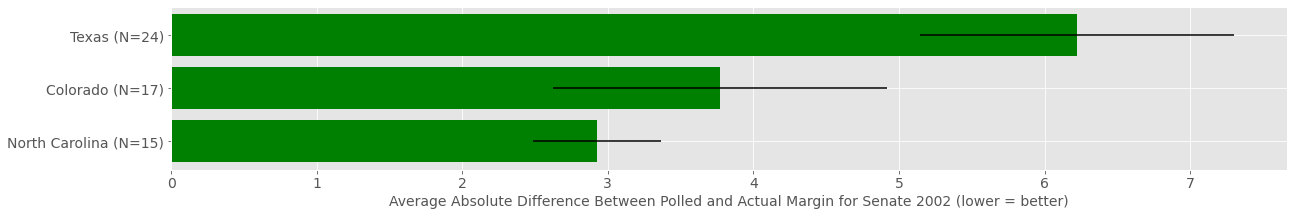

-
## Governor 2002 ##
          state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0  Pennsylvania           18.000000            9.121227          8.878773   
1      Michigan           11.000000            4.034291          6.965709   
2       Florida           -6.909091          -12.933577          6.024486   
3      Colorado          -34.571429          -29.490192         -5.081236   
4         Texas          -13.000000          -18.025204          5.025204   
5          Ohio          -16.116667          -19.829167          3.712500   

   polled_margin_count  
0                   12  
1                   16  
2                   22  
3                   14  
4                   22  
5                   12  
(6, 5)


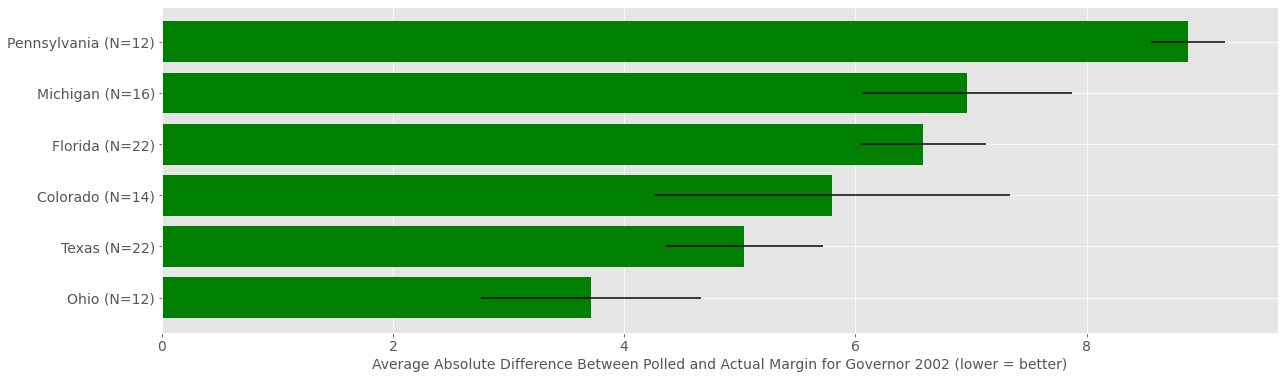

-
## President 2000 ##
          state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0     Wisconsin            0.208333            0.225256         -0.016922   
1  Pennsylvania            0.950500            4.233820         -3.283320   
2      Michigan            1.840909            5.208062         -3.367153   
3       Florida            1.683333           -0.010118          1.693452   
4          Ohio           -6.850000           -3.574973         -3.275027   
5          Iowa            0.333333            0.325358          0.007976   

   polled_margin_count  
0                   24  
1                   40  
2                   44  
3                   30  
4                   24  
5                   12  
(6, 5)


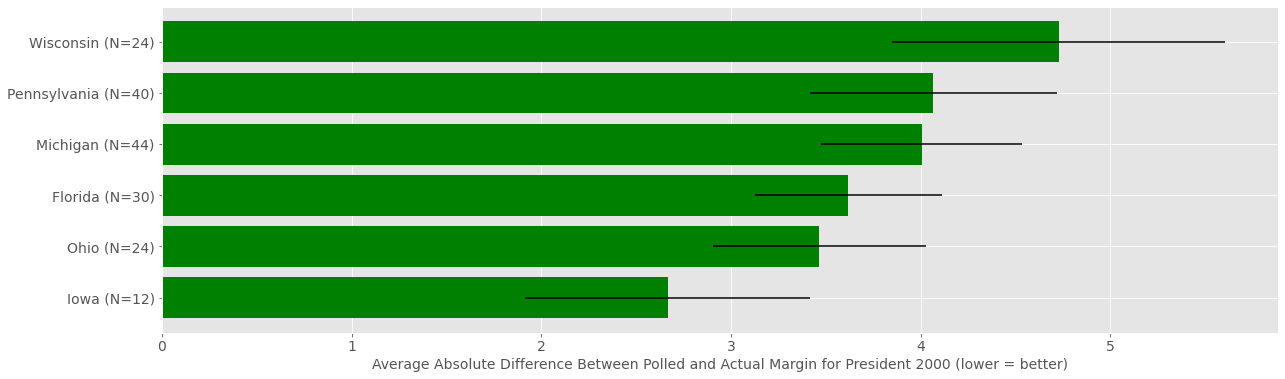

-
## Senate 2000 ##
          state  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0  Pennsylvania          -16.964286           -6.978030         -9.986255   
1     Wisconsin           30.235294           24.666076          5.569218   
2      Michigan           -2.428571            1.632083         -4.060655   
3          Ohio          -25.075000          -24.560682         -0.514318   
4       Florida            4.666667            4.915796         -0.249130   

   polled_margin_count  
0                   28  
1                   17  
2                   28  
3                   24  
4                   21  
(5, 5)


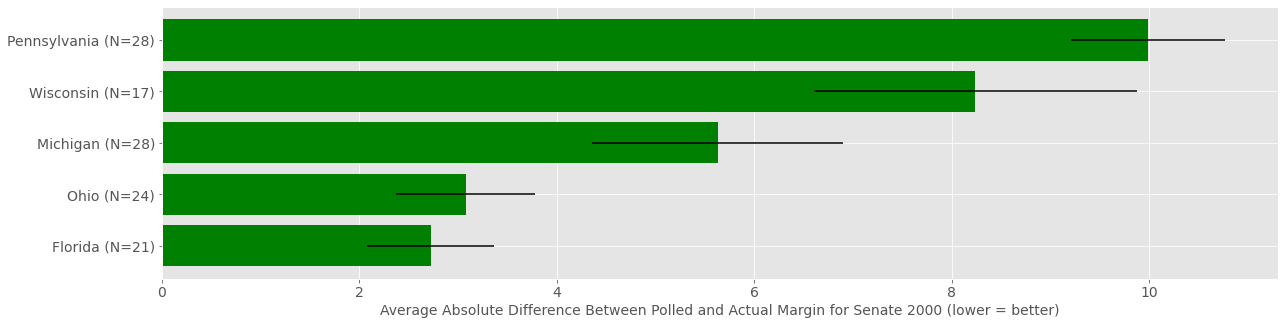

-
## Governor 2000 ##
-


In [144]:
for y in [2020, 2018, 2016, 2014, 2012, 2010, 2008, 2006, 2004, 2002, 2000]:
    for p in ['president', 'senate', 'governor']:
        print('## {} {} ##'.format(p.title(), y))
        plot_polls(polls, grouper='state', election=p, year=y)
        print('-')

## 538 Grade

## President 2020 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0               A            3.887755           -1.263561          5.151317   
1               B            3.540411           -0.915682          4.456093   
2               C            3.385036           -0.798578          4.183614   
3             D/F            2.895833           -1.169520          4.065353   

   polled_margin_count  
0                   98  
1                  146  
2                  139  
3                  192  
(4, 5)


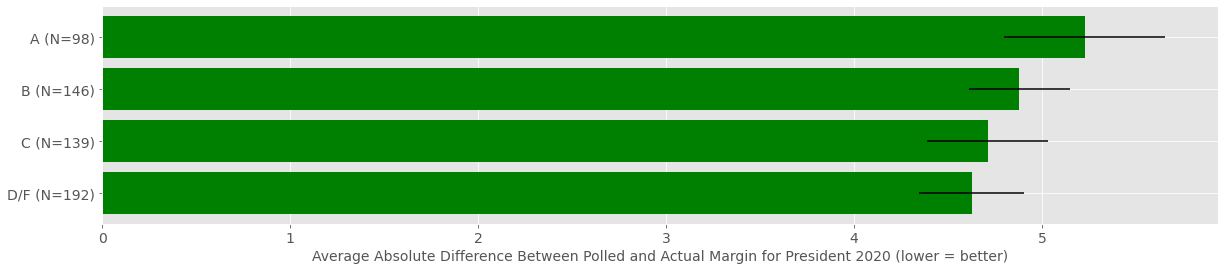

-
## Senate 2020 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0             D/F            4.254286           -2.651643          6.905929   
1               A            2.864262           -3.079742          5.944004   
2               B            2.659677           -2.420833          5.080510   
3               C            3.940909           -1.087799          5.028708   

   polled_margin_count  
0                   35  
1                   61  
2                   62  
3                   66  
(4, 5)


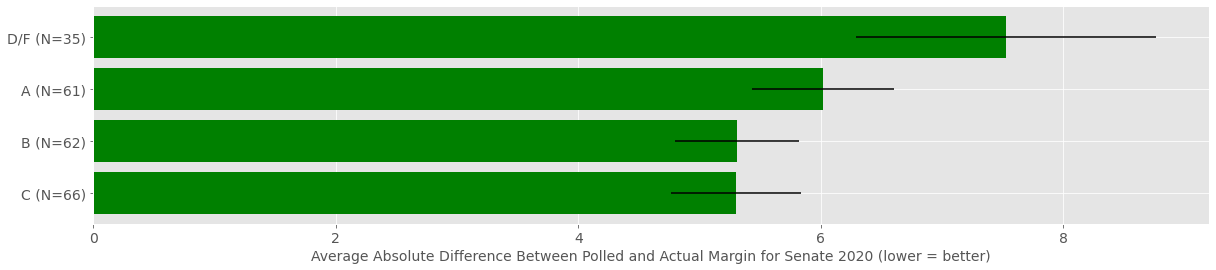

-
## Governor 2020 ##
-
## Gcb 2020 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0               B            9.500000            3.100000          6.400000   
1               C            7.003478            3.100000          3.903478   

   polled_margin_count  
0                   16  
1                   46  
(2, 5)


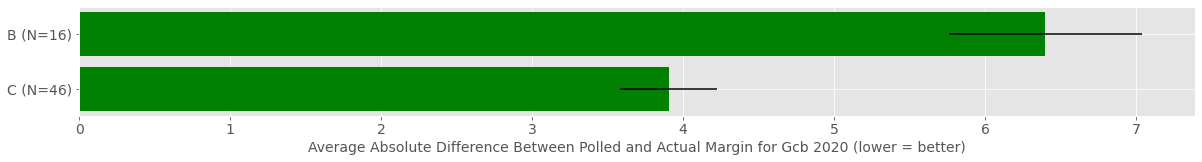

-
## President 2018 ##
-
## Senate 2018 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0               C            1.255372            2.112392         -0.857020   
1               A            2.536744            2.174037          0.362707   
2               B            5.630545            4.486278          1.144267   
3             D/F            2.258065            3.726216         -1.468151   

   polled_margin_count  
0                  121  
1                   43  
2                   55  
3                   31  
(4, 5)


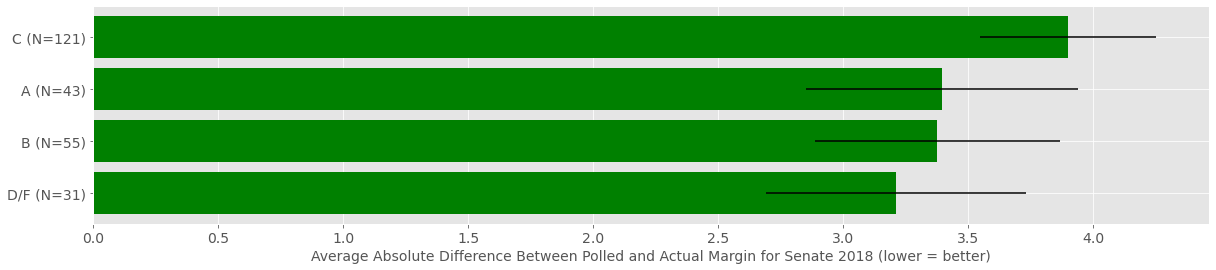

-
## Governor 2018 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0             D/F            1.976923            3.000769         -1.023846   
1               C            0.058163           -0.773061          0.831224   
2               B            0.162963            0.435556         -0.272593   
3               A            0.949000           -0.790500          1.739500   

   polled_margin_count  
0                   13  
1                   49  
2                   27  
3                   20  
(4, 5)


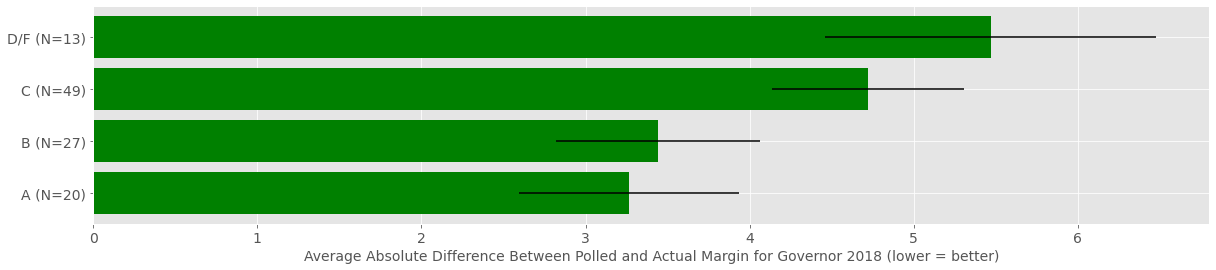

-
## Gcb 2018 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0               C            7.358209            8.600000         -1.241791   
1               B            7.144928            8.600000         -1.455072   
2               A            8.400000            8.600000         -0.200000   

   polled_margin_count  
0                   67  
1                   69  
2                   19  
(3, 5)


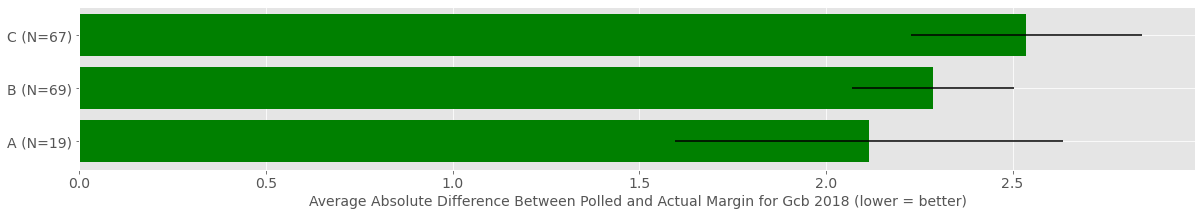

-
## President 2016 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0               C            1.537632           -1.878816          3.416447   
1             D/F            0.331447           -2.606447          2.937895   
2               B            1.101923           -2.432500          3.534423   
3               A           -0.086486           -2.832162          2.745676   

   polled_margin_count  
0                   76  
1                   76  
2                   52  
3                   37  
(4, 5)


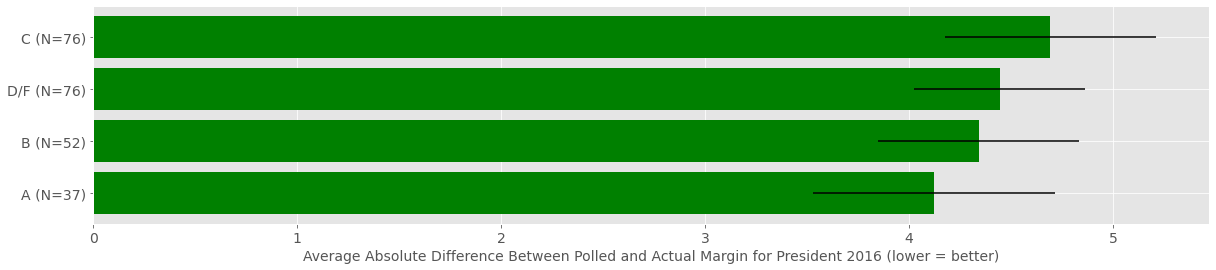

-
## Senate 2016 ##
  538grade_simple  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0             D/F           -5.066667           -8.827333          3.760667   
1               C           -1.243137           -4.972157          3.729020   
2               B           -3.700000           -7.699524          3.999524   
3               A           -5.370000           -6.919667          1.549667   

   polled_margin_count  
0                   30  
1                   51  
2                   42  
3                   30  
(4, 5)


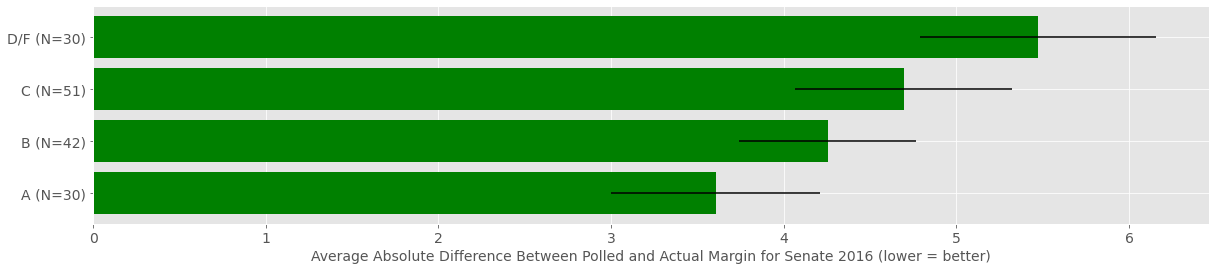

-
## Governor 2016 ##
-
## Gcb 2016 ##
-


In [145]:
for y in [2020, 2018, 2016]:
    for p in ['president', 'senate', 'governor', 'GCB']:
        print('## {} {} ##'.format(p.title(), y))
        plot_polls(polls[polls['538grade_simple'] != 'Unknown'], grouper='538grade_simple', election=p, year=y)
        print('-')

## President 2020 ##
             state 538grade_simple  polled_margin_mean  actual_margin_mean  \
0             Ohio               B            2.500000           -8.031962   
1        Wisconsin               A           10.185714            0.627100   
2             Iowa               A            1.100000           -8.152965   
3             Iowa             D/F            0.333333           -8.152965   
4             Iowa               C           -0.250000           -8.152965   
5             Iowa               B           -0.275000           -8.152965   
6        Wisconsin             D/F            8.206667            0.627100   
7          Florida               A            3.416667           -3.358369   
8         Nebraska             D/F          -12.375000          -19.057532   
9         Michigan               C            8.261538            2.783528   
10       Wisconsin               B            7.200000            0.627100   
11       Wisconsin               C         

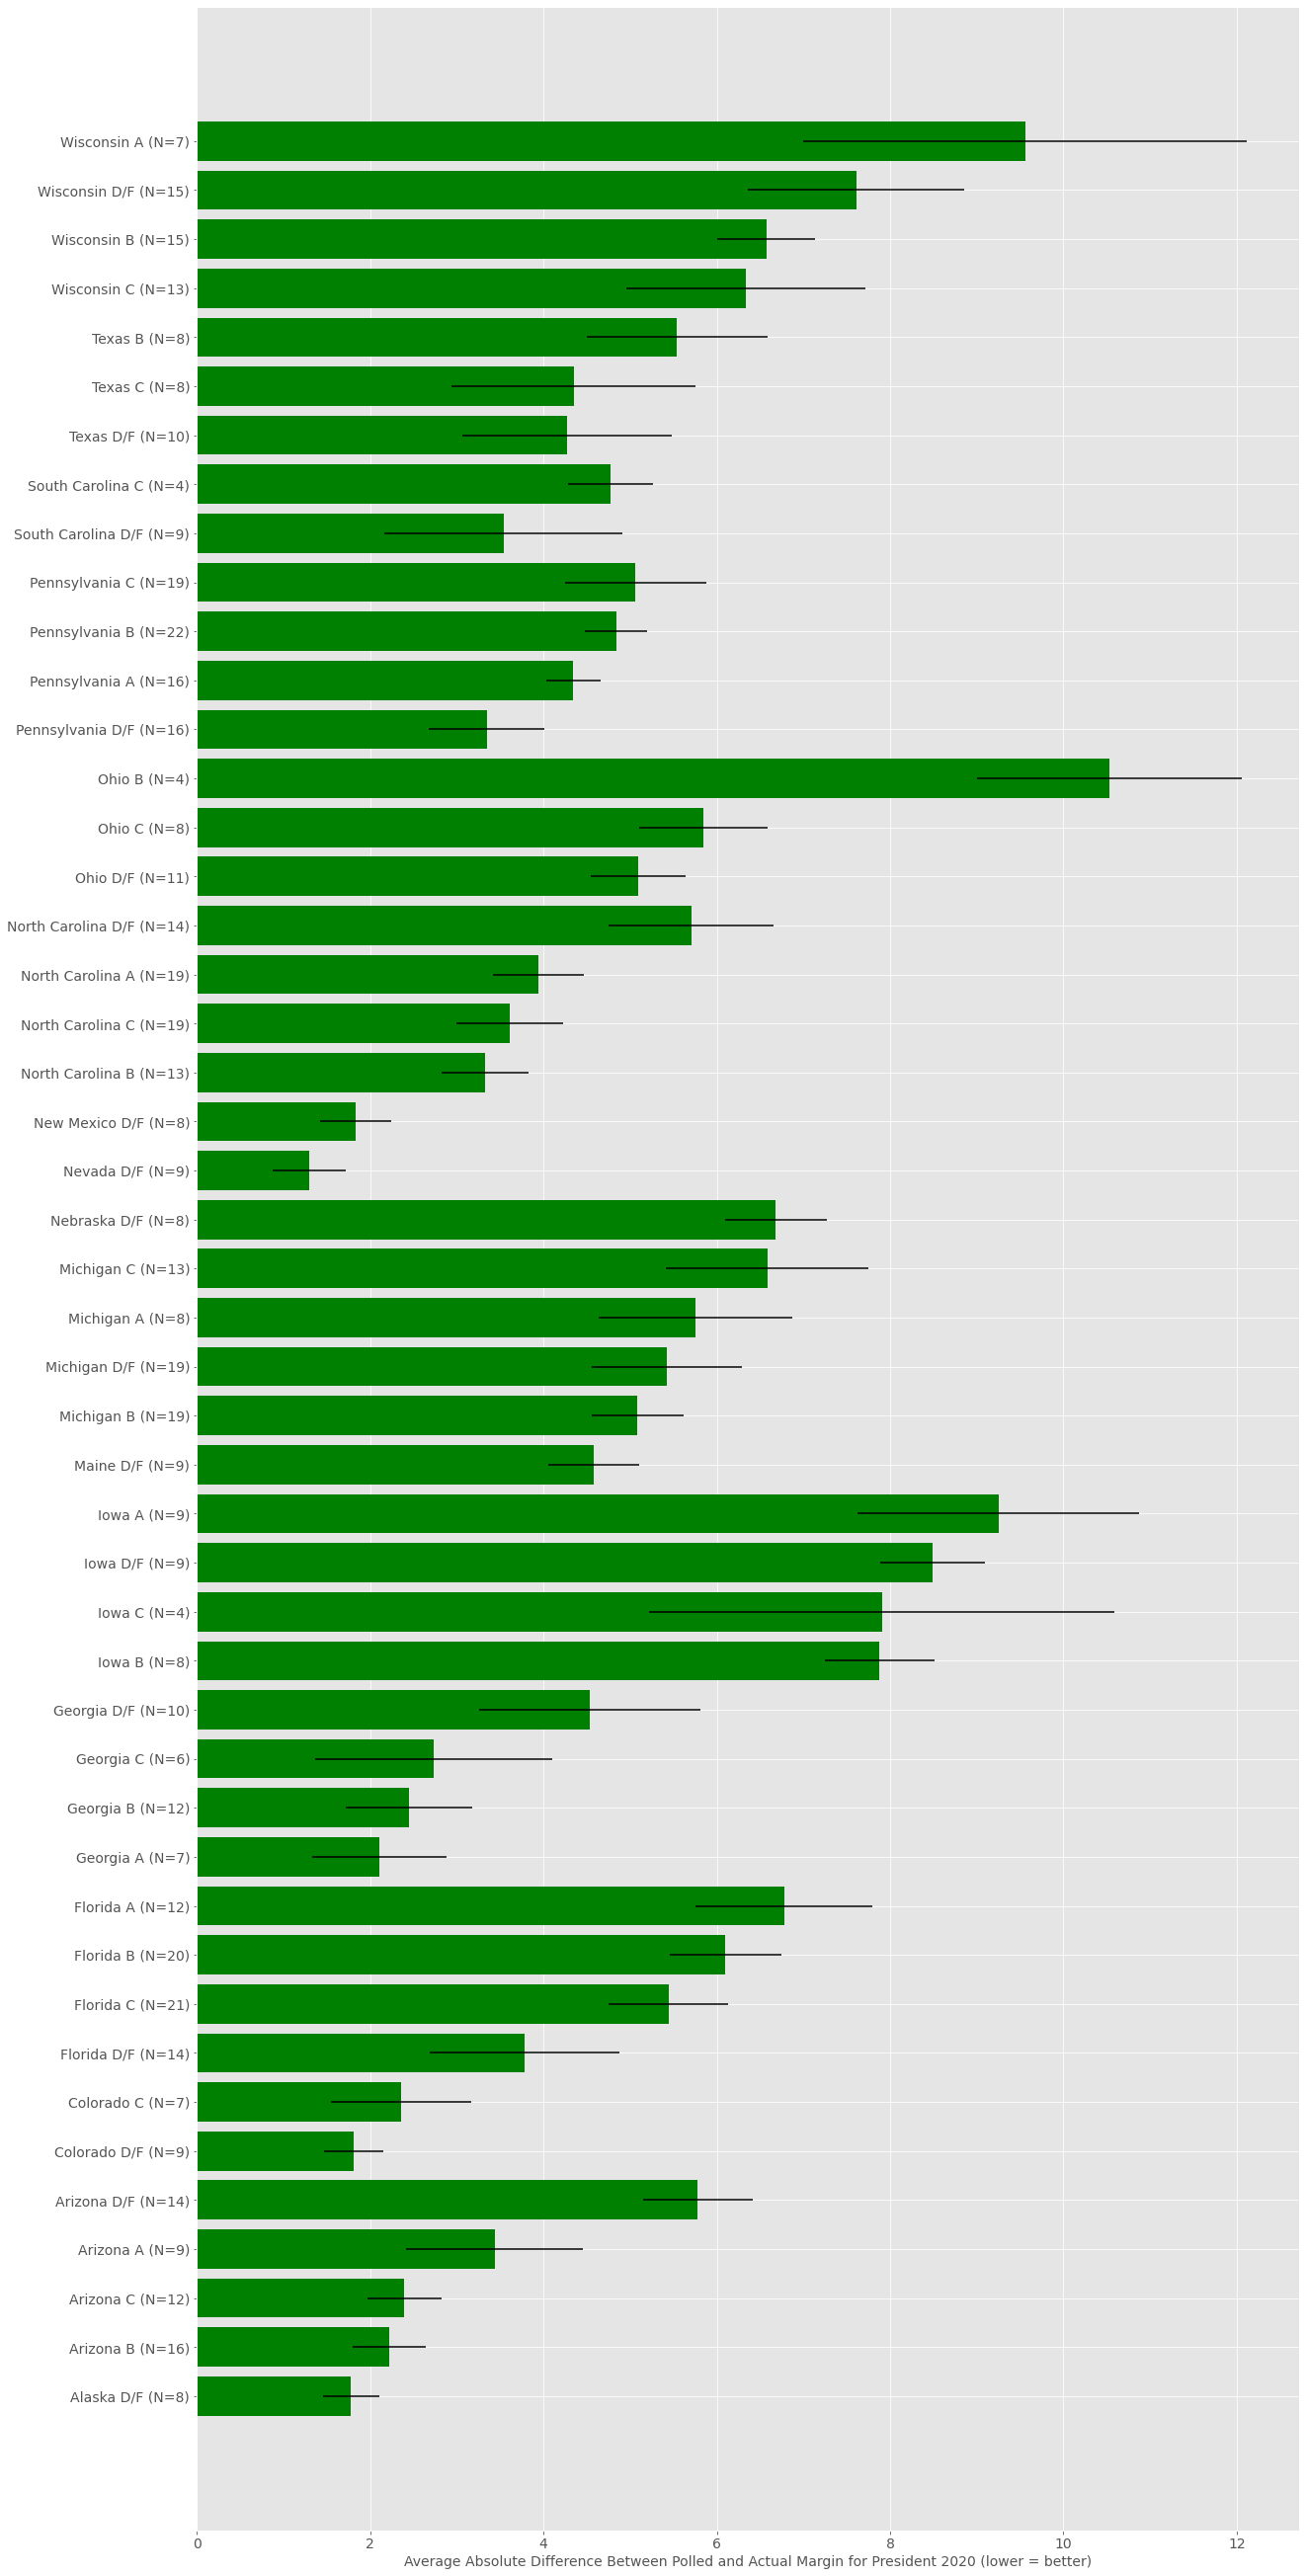

-
## Senate 2020 ##
             state 538grade_simple  polled_margin_mean  actual_margin_mean  \
0            Maine             D/F            6.000000           -8.501941   
1            Maine               A            1.560000           -8.501941   
2         Michigan               C            9.366667            1.685031   
3             Iowa               B            1.137500           -6.478210   
4             Iowa               A            1.113333           -6.478210   
5   South Carolina               C           -2.860000          -10.270311   
6   North Carolina               A            4.378571           -1.746737   
7          Arizona               B            7.662500            2.348697   
8         Michigan             D/F            5.711111            1.685031   
9   North Carolina               C            3.820000           -1.746737   
10         Arizona             D/F            7.700000            2.348697   
11        Michigan               B          

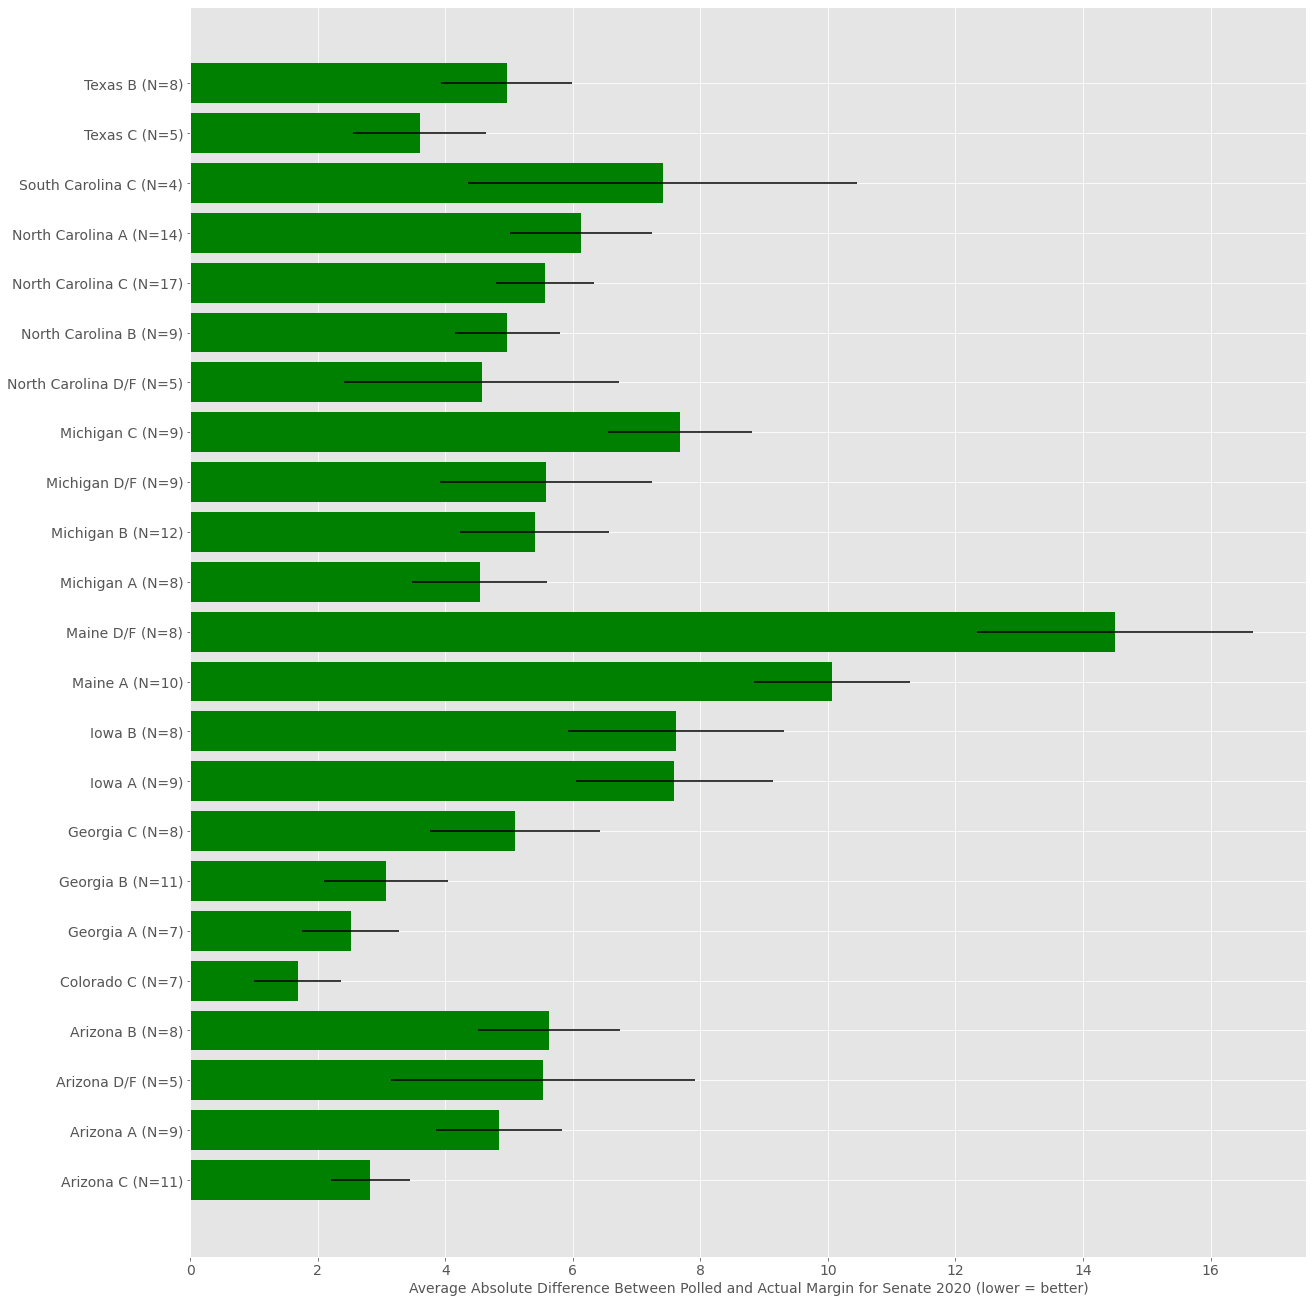

-
## Governor 2020 ##
-
## President 2018 ##
-
## Senate 2018 ##
        state 538grade_simple  polled_margin_mean  actual_margin_mean  \
0        Ohio               C           14.250000            6.842886   
1      Nevada               B           -1.850000            5.028496   
2    Michigan               C           12.540000            6.502801   
3        Ohio               B           12.200000            6.842886   
4     Florida               A            5.116667           -0.121460   
5     Arizona               C           -1.596000            2.346477   
6       Texas             D/F           -4.450000           -2.563623   
7      Nevada               A            0.582000            5.027594   
8      Nevada               C            1.372222            5.027828   
9    Michigan               B           10.000000            6.502801   
10      Texas               C           -5.863636           -2.565270   
11    Florida               B            3.114286          

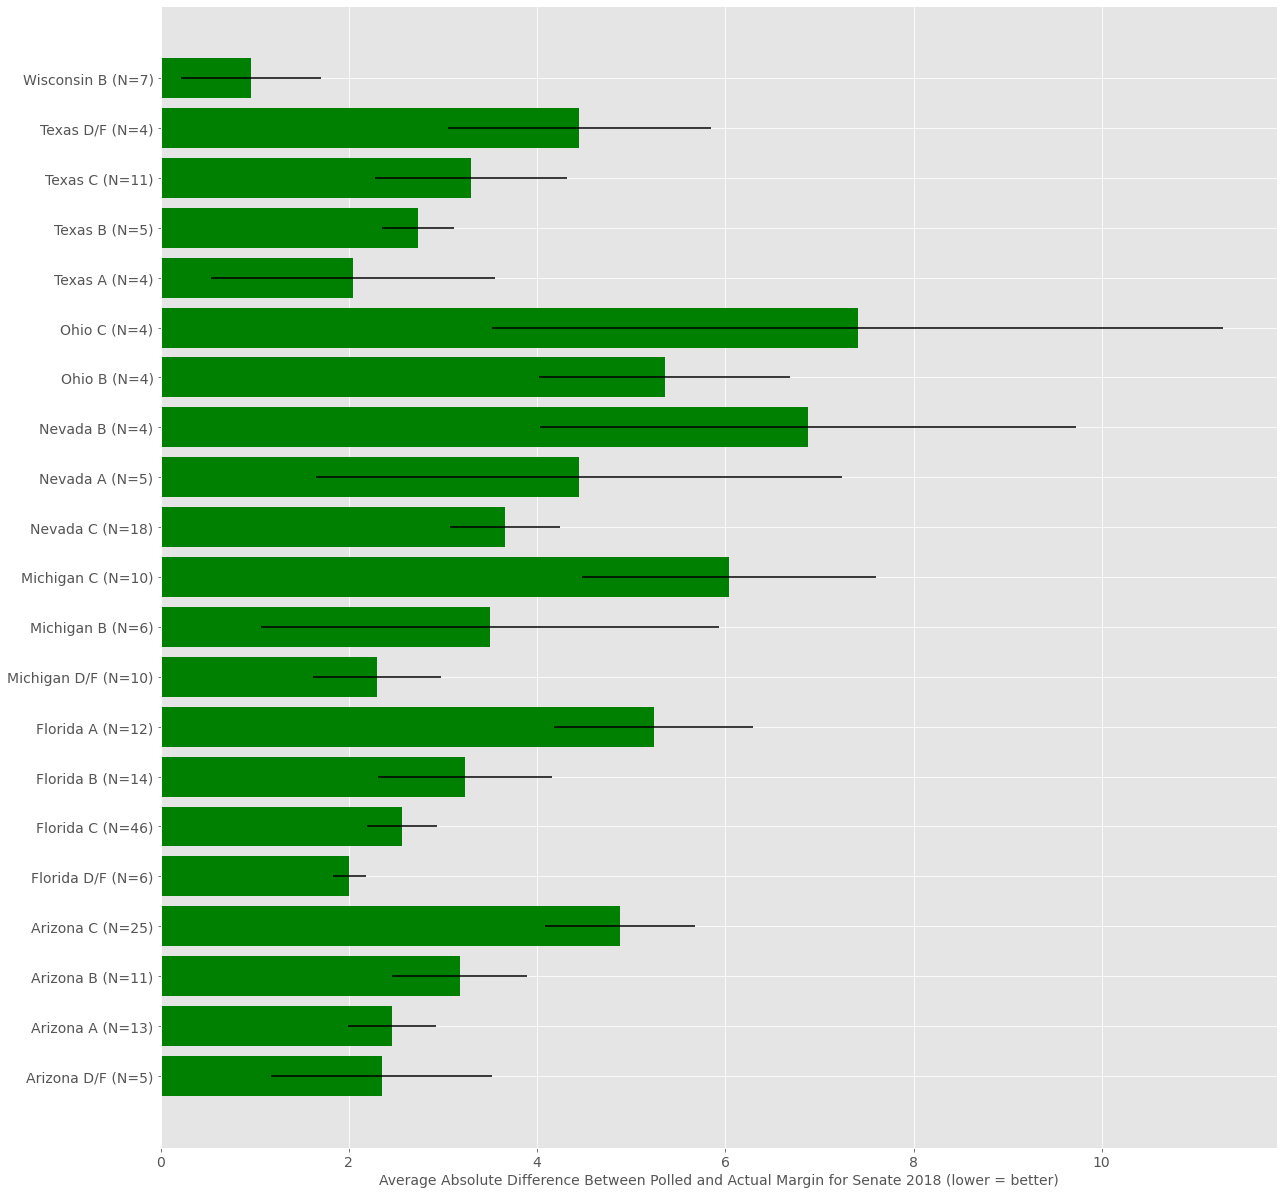

-
## Governor 2018 ##
      state 538grade_simple  polled_margin_mean  actual_margin_mean  \
0   Florida               A            4.336000           -0.400000   
1   Arizona               C          -15.237500          -14.160000   
2   Florida               B            3.771429           -0.400000   
3   Florida               C            2.916667           -0.400000   
4    Nevada               C            0.380000            4.080000   
5  Michigan               C           10.250000            9.560000   
6  Michigan             D/F            8.700000            9.560000   

   margin_diff_mean  polled_margin_count  
0          4.736000                    5  
1         -1.077500                    8  
2          4.171429                    7  
3          3.316667                   18  
4         -3.700000                    5  
5          0.690000                    4  
6         -0.860000                    4  
(7, 6)


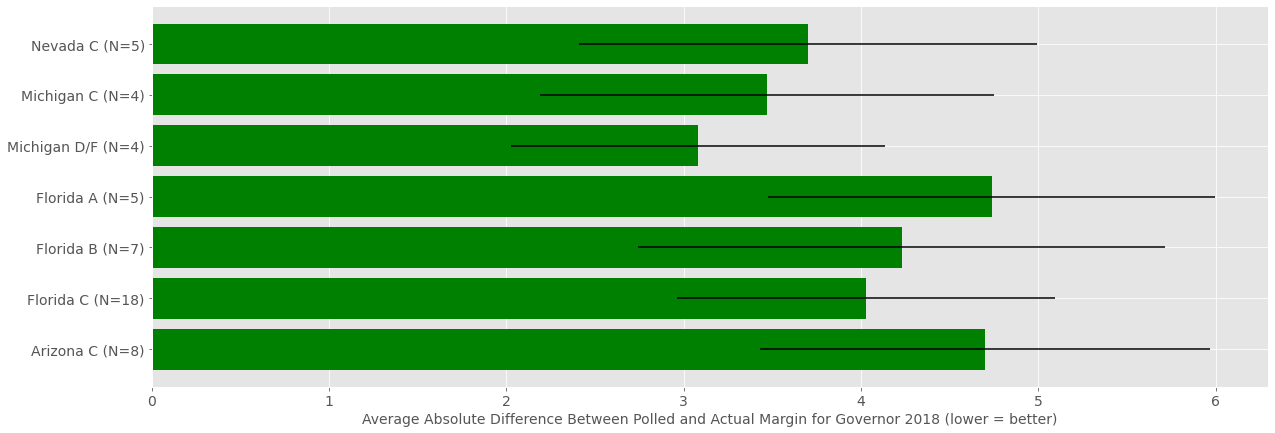

-


In [146]:
for y in [2020, 2018]:
    for p in ['president', 'senate', 'governor']:
        print('## {} {} ##'.format(p.title(), y))
        plot_polls(polls[polls['538grade_simple'] != 'Unknown'],
                   grouper=['state', '538grade_simple'], election=p, year=y, count_filter=3)
        print('-')

## Methodology

       methodology  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0      Online/Text            3.418182           -1.460370          4.878552   
1      Online/Live            1.116822           -0.002617          1.119439   
2       IVR/Online           -1.284629           -0.931028         -0.353600   
3              IVR            0.107386            3.447395         -3.340009   
4           Online            1.895835            0.220499          1.675336   
5       Live Phone            0.485555           -0.114487          0.600042   
6         IVR/Live            1.986129            0.442688          1.543441   
7  IVR/Online/Live           -0.843713           -1.524926          0.681213   
8  IVR/Online/Text            0.631923           -1.540617          2.172541   
9         IVR/Text            1.794156            0.501695          1.292461   

   polled_margin_count  
0                   55  
1                  107  
2                  404  
3                  

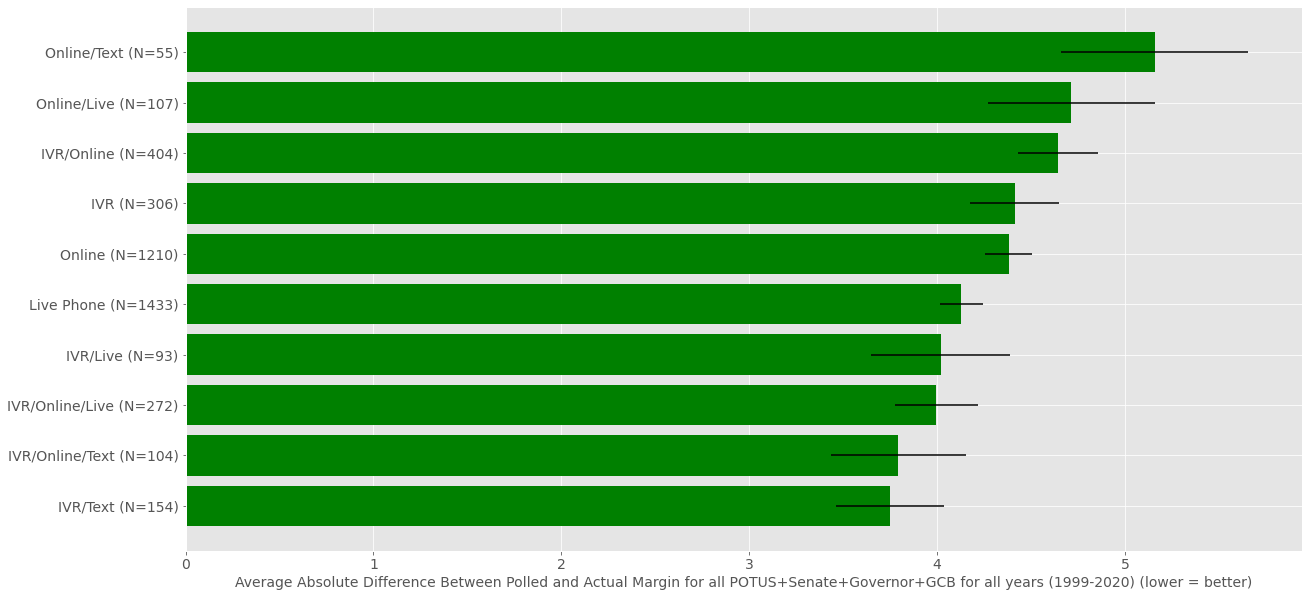

In [147]:
plot_polls(polls[polls['methodology'] != 'Unknown'], grouper='methodology', election=None, year=None, count_filter=50)

       methodology  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0      Online/Text            3.418182           -1.460370          4.878552   
1       IVR/Online            0.593851           -1.993326          2.587177   
2       Live Phone            2.823920           -0.701471          3.525391   
3           Online            3.853865            0.736462          3.117403   
4  IVR/Online/Live            0.881818           -1.882727          2.764545   
5         IVR/Live            0.714464           -0.814643          1.529107   
6  IVR/Online/Text            0.631923           -1.540617          2.172541   
7              IVR           -0.190000            0.993102         -1.183102   

   polled_margin_count  
0                   55  
1                  161  
2                  426  
3                  727  
4                   55  
5                   56  
6                  104  
7                   64  
(8, 5)


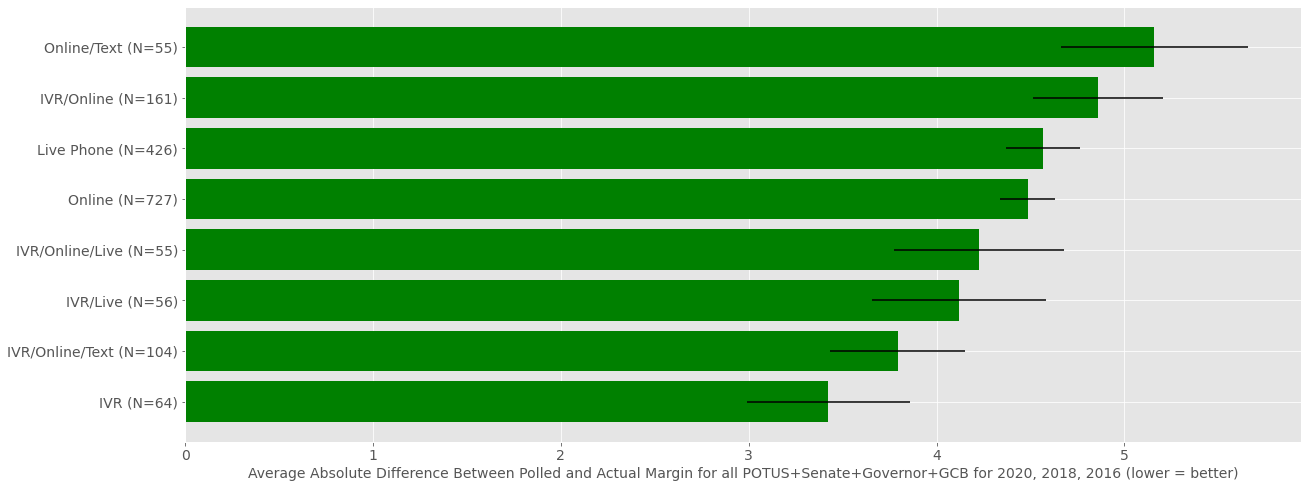

In [148]:
plot_polls(polls[polls['methodology'] != 'Unknown'], grouper='methodology', election=None, year=[2020, 2018, 2016], count_filter=50)

       methodology  polled_margin_mean  actual_margin_mean  margin_diff_mean  \
0       IVR/Online           -2.039286            0.151845         -2.191131   
1              IVR            0.186033            4.096464         -3.910431   
2       Live Phone            1.282500            1.740048         -0.457548   
3  IVR/Online/Live           -0.858586            0.358283         -1.216869   
4         IVR/Text            1.260833            1.004417          0.256417   
5           Online            0.269118            0.900756         -0.631638   

   polled_margin_count  
0                  168  
1                  242  
2                  548  
3                   99  
4                  120  
5                  272  
(6, 5)


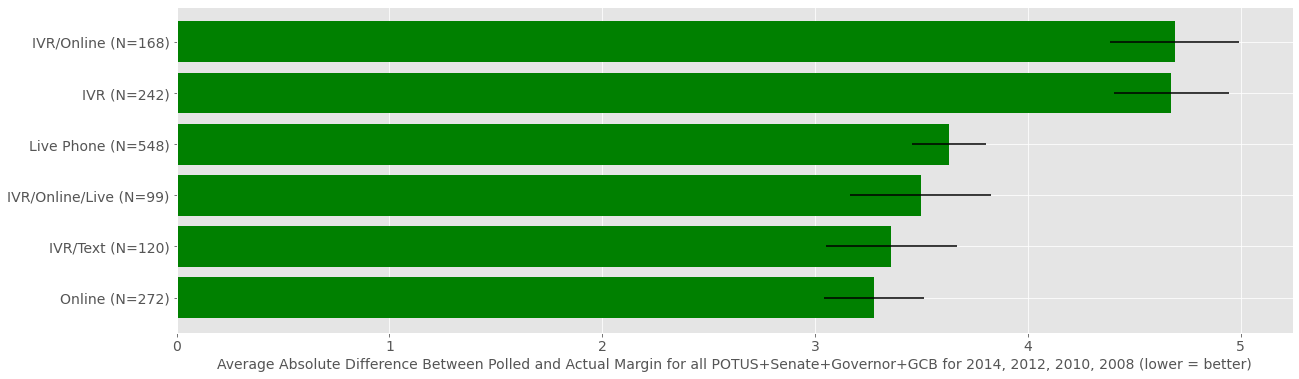

In [153]:
plot_polls(polls[polls['methodology'] != 'Unknown'], grouper='methodology', election=None, year=[2014, 2012, 2010, 2008], count_filter=50)

## Pollster

                                    pollster  polled_margin_mean  \
0                      Quinnipiac University            2.710526   
1                                       SSRS            6.750000   
2         Mitchell Research & Communications            7.229167   
3               Redfield & Wilton Strategies            6.611111   
4                        Monmouth University            3.903226   
5                                   Swayable            4.120000   
6                                     Civiqs            5.214286   
7    Siena College/The New York Times Upshot            3.210526   
8                      Public Policy Polling            4.166667   
9                            Morning Consult            4.159091   
10              ABC News/The Washington Post            4.714286   
11                           Change Research            5.000000   
12                                     Ipsos            4.771930   
13                              SurveyMonkey    

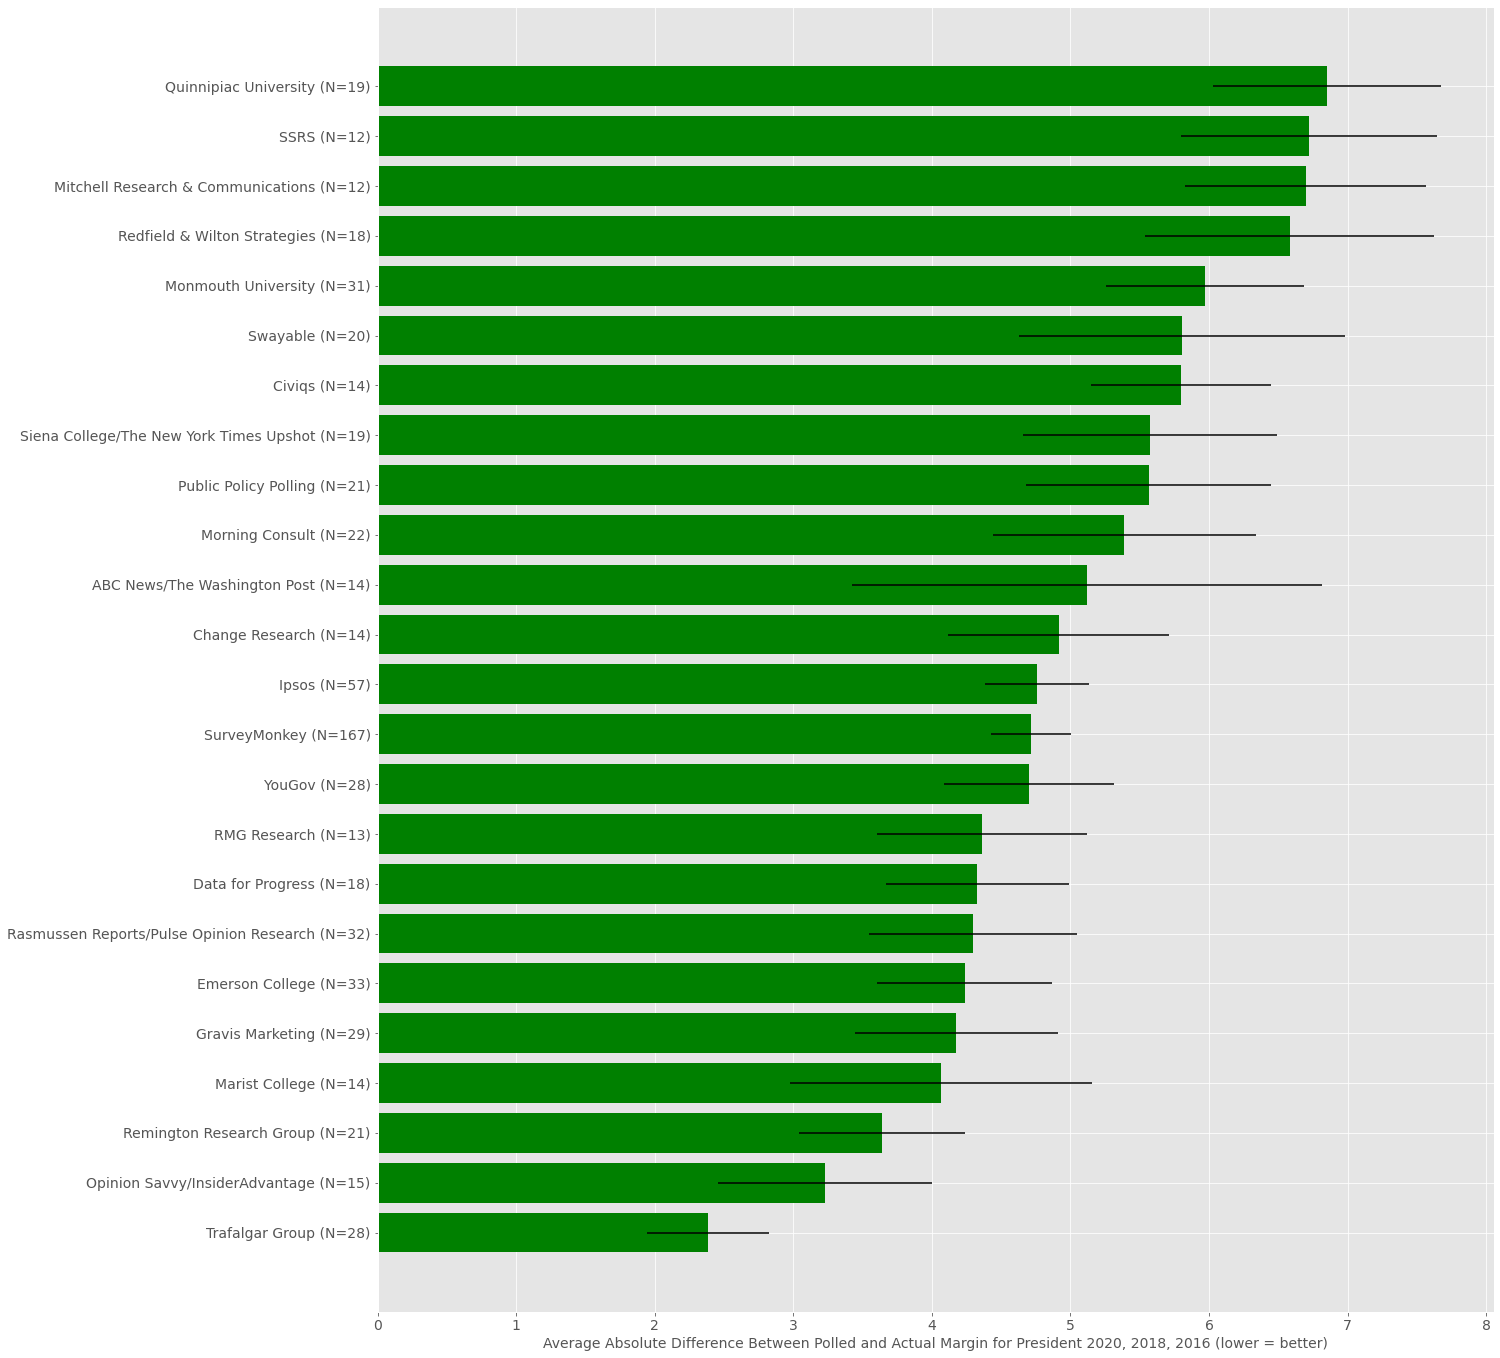

In [156]:
plot_polls(polls, grouper='pollster', election='president', year=[2020, 2018, 2016])

                                    pollster  polled_margin_mean  \
0                          Zogby (Internet)             1.384615   
1                               TCJ Research           -2.227273   
2             Zogby Interactive/JZ Analytics            2.218750   
3                                        ARG           -0.882353   
4                    American Research Group            0.818182   
5                         InAdv/PollPosition            2.666667   
6       Mason-Dixon Polling & Research, Inc.            1.133333   
7                           InsiderAdvantage            2.333333   
8   Rasmussen Reports/Pulse Opinion Research            0.610169   
9             Mason-Dixon Polling & Strategy            1.133333   
10            Opinion Savvy/InsiderAdvantage            2.333333   
11                                 Rasmussen            1.181818   
12                         InsiderAdvantage             3.076923   
13                              Mason-Dixon     

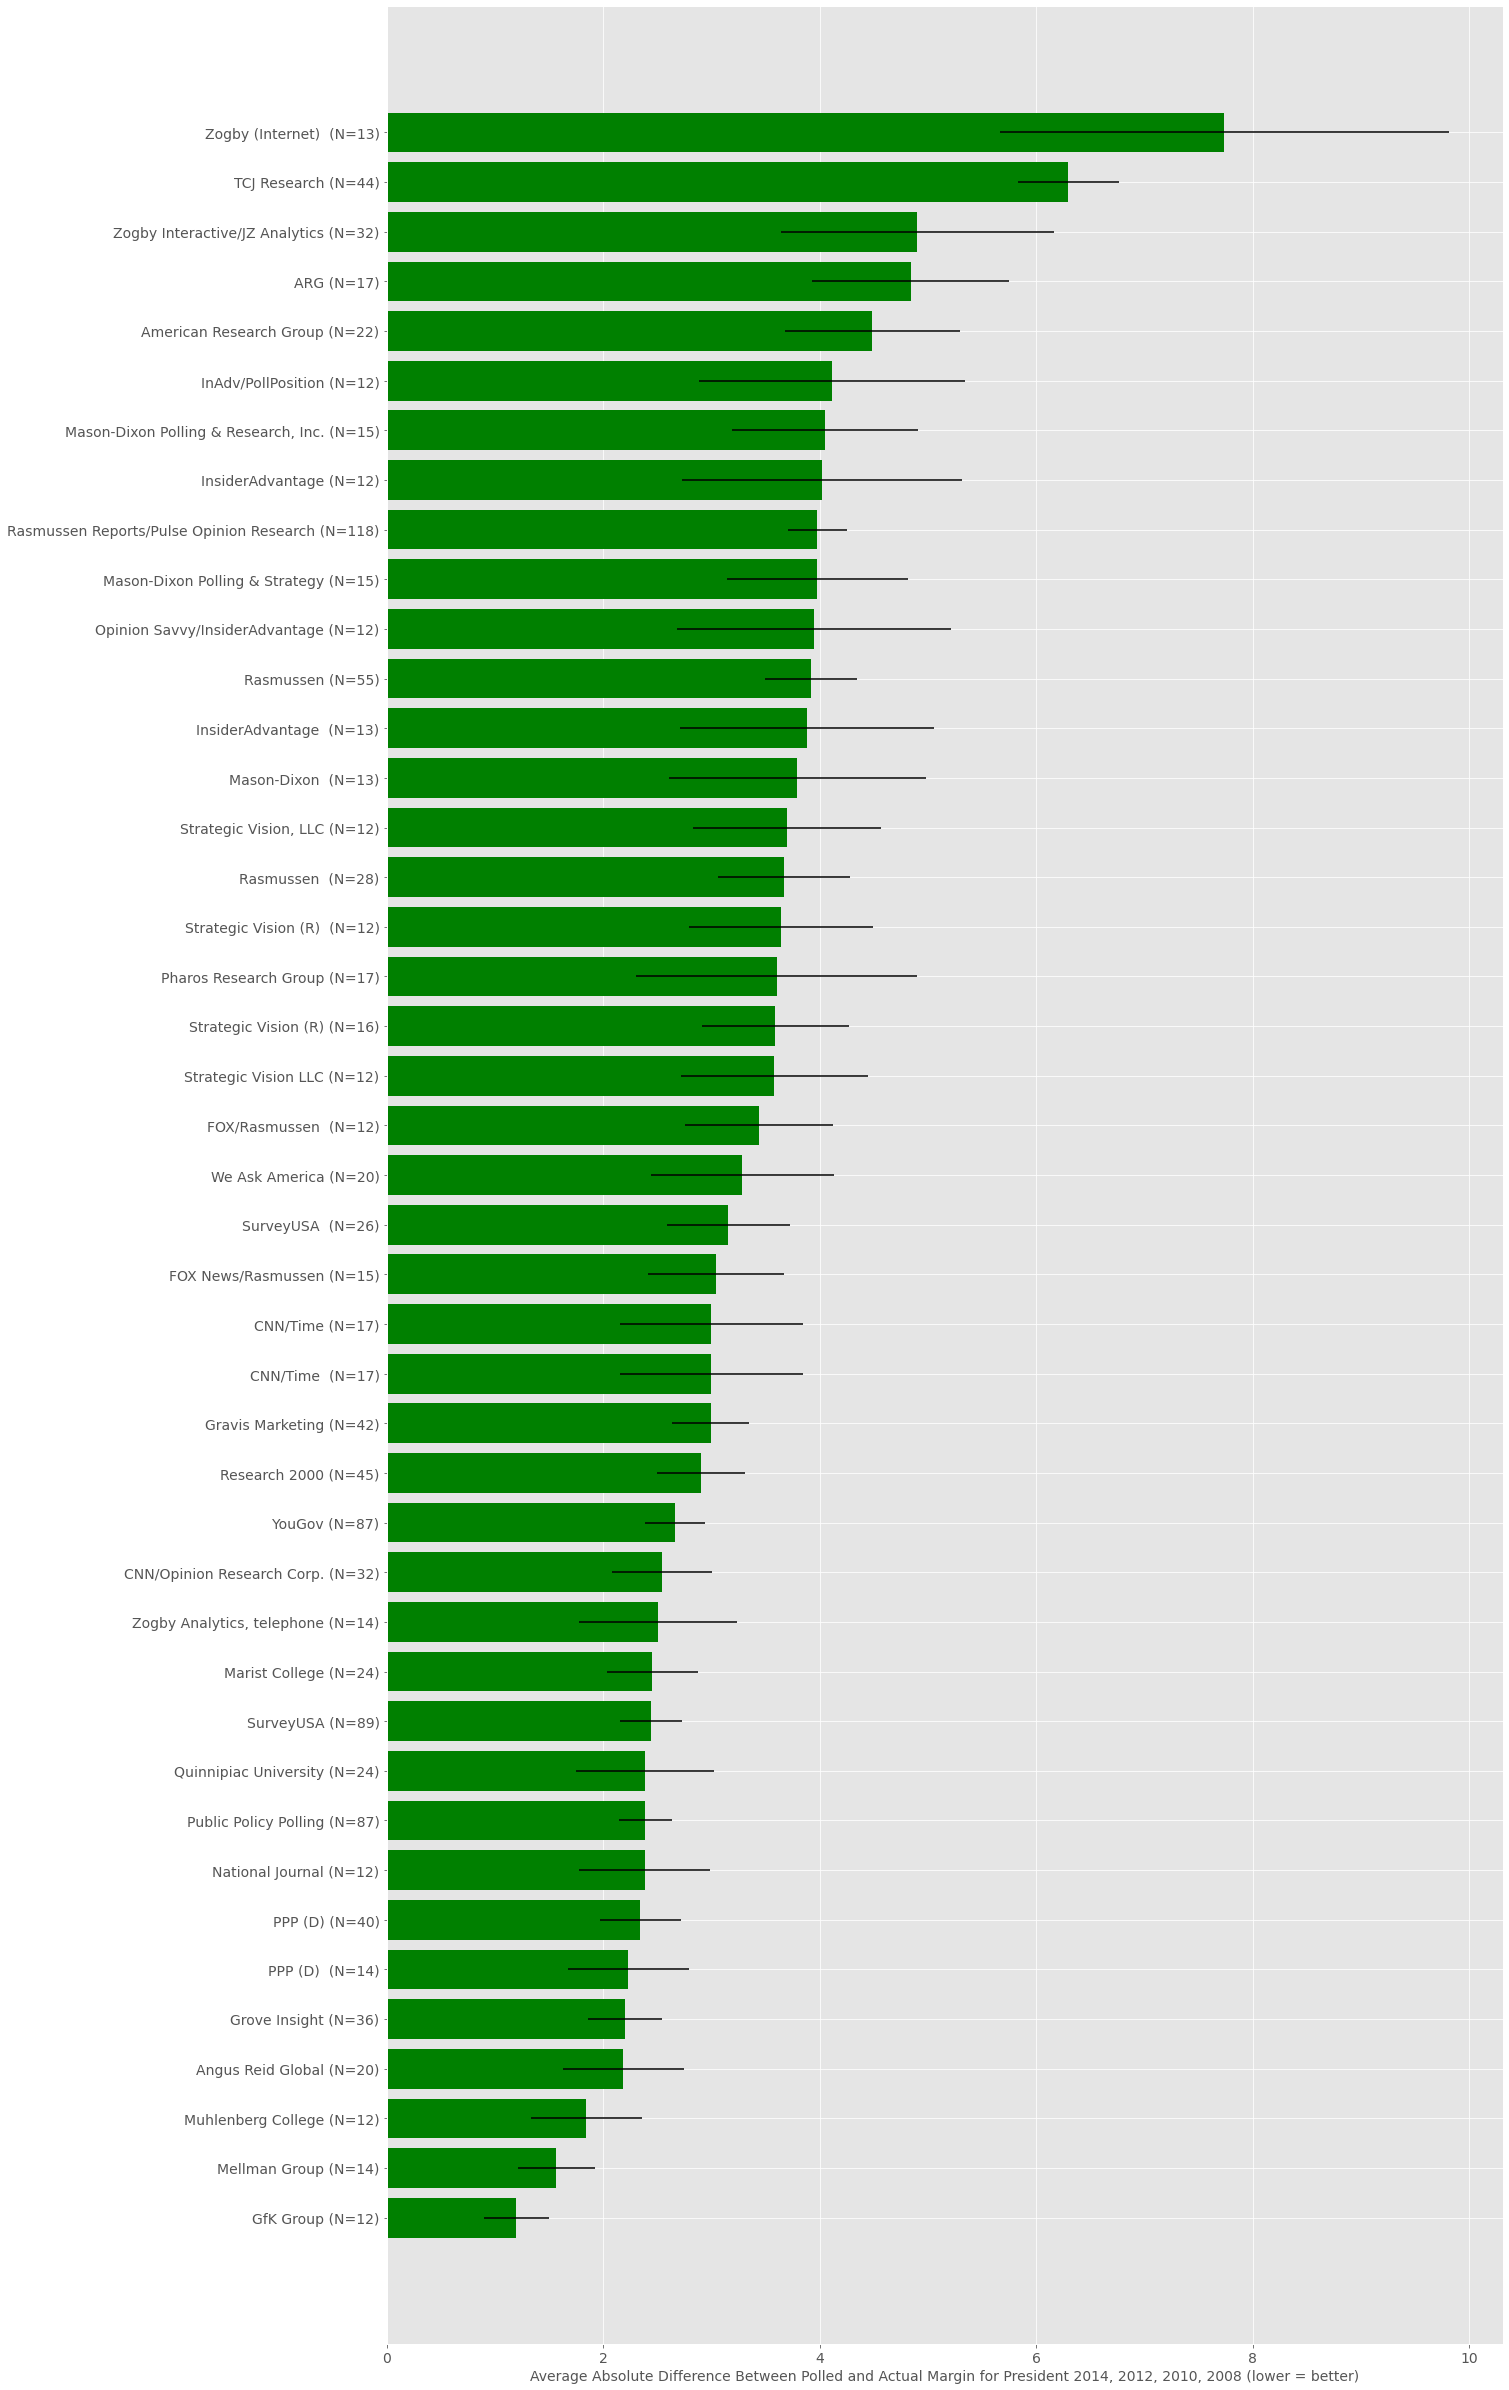

In [157]:
plot_polls(polls, grouper='pollster', election='president', year=[2014, 2012, 2010, 2008])